In [135]:
import os

import pandas as pd
import io
import requests
import numpy as np
import math
import itertools    

from sklearn import preprocessing
from sklearn import model_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras

print(tf.version)

from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.optimizers import SGD
from keras.optimizers import Adam, Adamax, Adagrad, Ftrl

import matplotlib.pyplot as plt


from rbf_tf.rbflayer import RBFLayer, InitCentersRandom
from rbf_tf.kmeans_initializer import InitCentersKMeans

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/thyroid-disease/ann-train.data"
s = requests.get(url).contents=requests.get(url).content
dataTrain=pd.read_csv(io.StringIO(s.decode('utf-8')),delimiter=' ',header=None)

dataTrain.head()

print(dataTrain.shape)
dataTrain.head()

<module 'tensorflow._api.v2.version' from 'c:\\users\\user\\appdata\\local\\programs\\python\\python38\\lib\\site-packages\\tensorflow\\_api\\v2\\version\\__init__.py'>
(3772, 24)


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.73,0,1,0,0,0,0,0,1,0,...,0,0,0.00060,0.015,0.120,0.082,0.146,3,NaN,NaN
1,0.24,0,0,0,0,0,0,0,0,0,...,0,0,0.00025,0.030,0.143,0.133,0.108,3,NaN,NaN
2,0.47,0,0,0,0,0,0,0,0,0,...,0,0,0.00190,0.024,0.102,0.131,0.078,3,NaN,NaN
3,0.64,1,0,0,0,0,0,0,0,0,...,0,0,0.00090,0.017,0.077,0.090,0.085,3,NaN,NaN
4,0.23,0,0,0,0,0,0,0,0,0,...,0,0,0.00025,0.026,0.139,0.090,0.153,3,NaN,NaN


In [136]:
del dataTrain[22]
del dataTrain[23]


del dataTrain[11]
del dataTrain[12]
del dataTrain[14]

In [137]:
dataTrain.head()

,0,1,2,3,4,5,6,7,8,9,10,13,15,16,17,18,19,20,21
0,0.73,0,1,0,0,0,0,0,1,0,0,0,0,0.00060,0.015,0.120,0.082,0.146,3
1,0.24,0,0,0,0,0,0,0,0,0,0,0,0,0.00025,0.030,0.143,0.133,0.108,3
2,0.47,0,0,0,0,0,0,0,0,0,0,0,0,0.00190,0.024,0.102,0.131,0.078,3
3,0.64,1,0,0,0,0,0,0,0,0,0,0,0,0.00090,0.017,0.077,0.090,0.085,3
4,0.23,0,0,0,0,0,0,0,0,0,0,0,0,0.00025,0.026,0.139,0.090,0.153,3


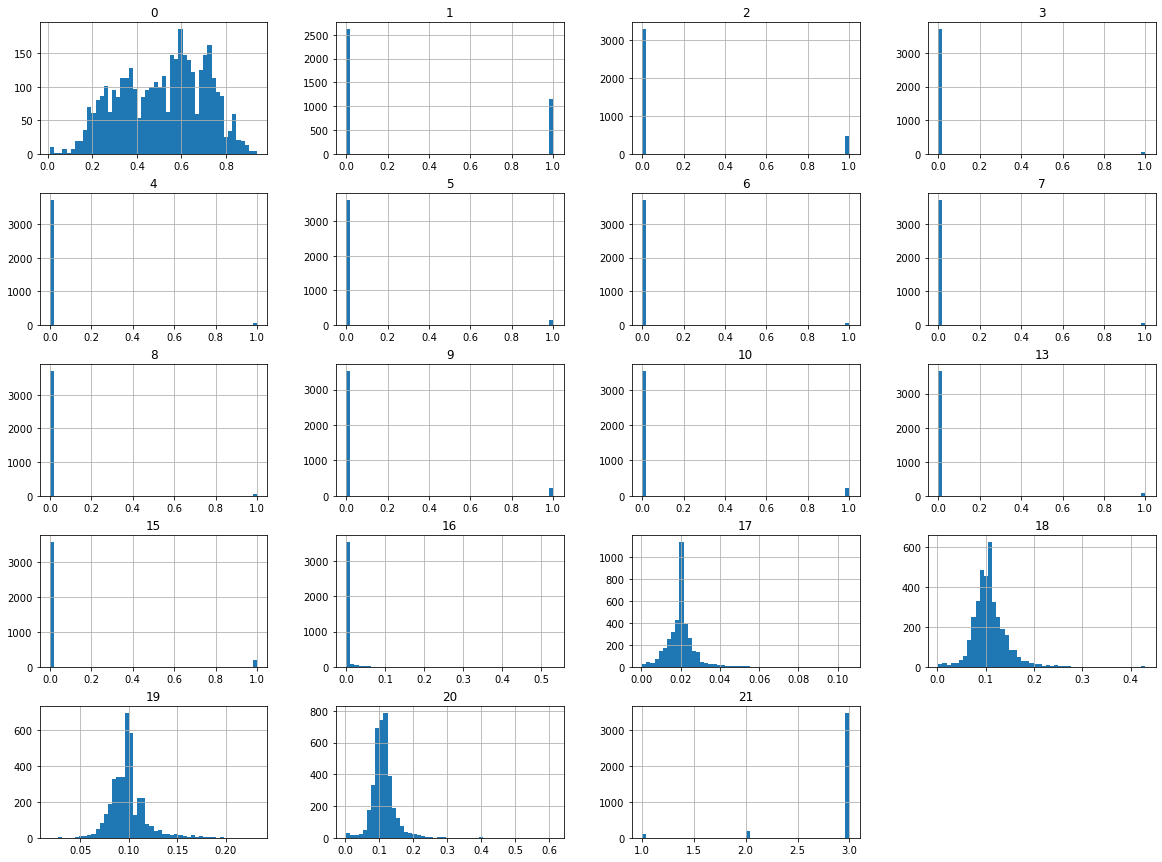

In [138]:
%matplotlib inline
import matplotlib.pyplot as plt
dataTrain.hist(bins=50, figsize=(20,15))
plt.show()

In [139]:
#Predictor data
inputTrain = dataTrain.drop([21], axis=1)
inputTrain.head()        

,0,1,2,3,4,5,6,7,8,9,10,13,15,16,17,18,19,20
0,0.73,0,1,0,0,0,0,0,1,0,0,0,0,0.00060,0.015,0.120,0.082,0.146
1,0.24,0,0,0,0,0,0,0,0,0,0,0,0,0.00025,0.030,0.143,0.133,0.108
2,0.47,0,0,0,0,0,0,0,0,0,0,0,0,0.00190,0.024,0.102,0.131,0.078
3,0.64,1,0,0,0,0,0,0,0,0,0,0,0,0.00090,0.017,0.077,0.090,0.085
4,0.23,0,0,0,0,0,0,0,0,0,0,0,0,0.00025,0.026,0.139,0.090,0.153


In [140]:
#Target data
outputTrain = dataTrain[21] - 1
outputTrain.head()

0    2
1    2
2    2
3    2
4    2
Name: 21, dtype: int64

In [141]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/thyroid-disease/ann-test.data"
s = requests.get(url).contents=requests.get(url).content
dataTest=pd.read_csv(io.StringIO(s.decode('utf-8')),delimiter=' ',header=None)

dataTest.head()

print(dataTest.shape)
dataTest.head()

(3428, 24)


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.29,0,0,0,0,0,0,0,0,0,...,0,0,0.0061,0.028,0.111,0.131,0.085,2,NaN,NaN
1,0.32,0,0,0,0,0,0,0,0,0,...,0,0,0.0013,0.019,0.084,0.078,0.107,3,NaN,NaN
2,0.35,0,0,0,0,0,0,0,0,0,...,0,0,0.0000,0.031,0.239,0.100,0.239,3,NaN,NaN
3,0.21,0,0,0,0,0,0,0,0,0,...,0,0,0.0010,0.018,0.087,0.088,0.099,3,NaN,NaN
4,0.22,0,0,0,0,1,0,0,0,0,...,0,0,0.0004,0.022,0.134,0.135,0.099,3,NaN,NaN


In [142]:
del dataTest[22]
del dataTest[23]


del dataTest[11]
del dataTest[12]
del dataTest[14]

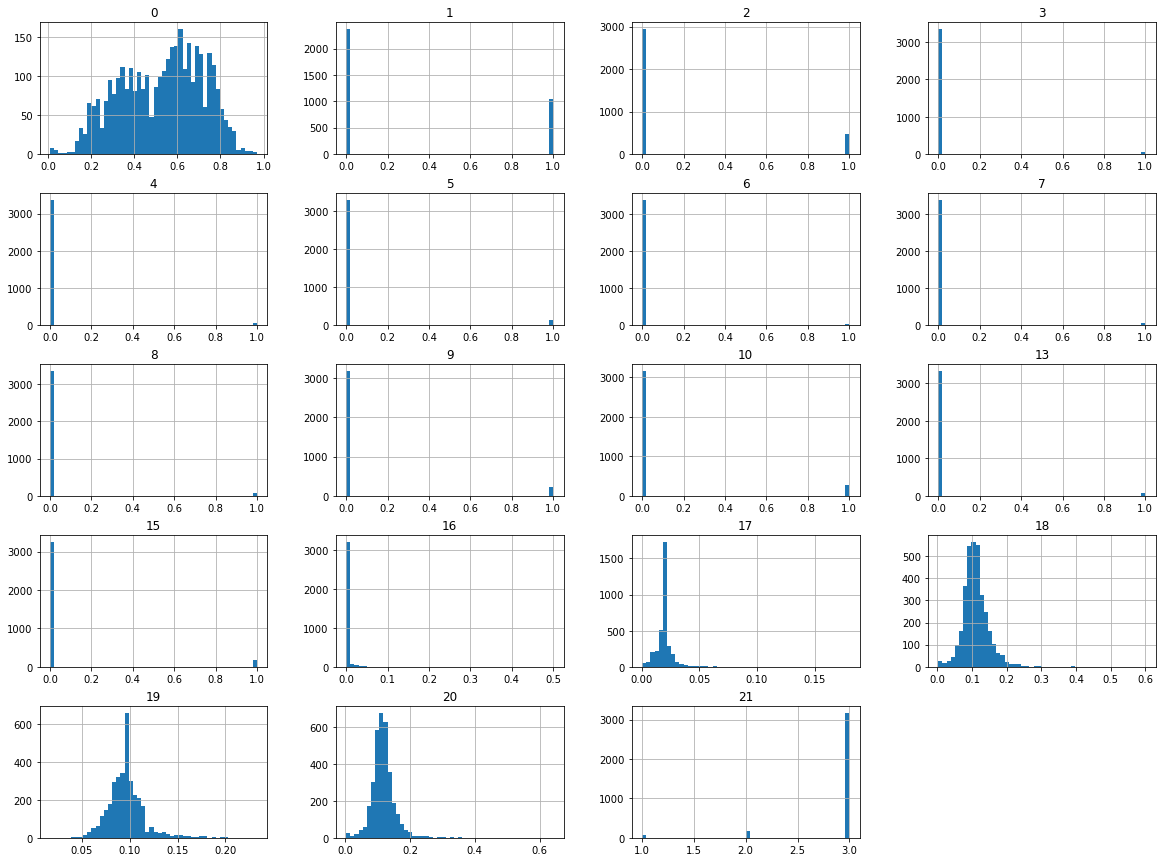

In [143]:
%matplotlib inline
import matplotlib.pyplot as plt
dataTest.hist(bins=50, figsize=(20,15))
plt.show()

In [144]:
inputTest = dataTest.drop([21], axis=1)
outputTest = dataTest[21] - 1

In [145]:
scaler = preprocessing.MinMaxScaler()
# fit using the train set
scaler.fit(inputTrain)
# transform the test test
xtrainN = scaler.transform(inputTrain)
xtestN = scaler.transform(inputTest) 

In [146]:
outputTrain_one_hot = keras.utils.to_categorical(outputTrain)

In [147]:
# '''print("Proporção das classes no dataset")
# counts = np.bincount(outputTrain)
# print(counts)
# print("Dados de Treinamento:",  counts/ float(len(outputTrain)))
# print("Dados de Teste:", np.bincount(outputTest) / float(len(outputTest)))

# peso_classe1 = 1.0/counts[0]
# peso_classe2 = 1.0/counts[1]
# peso_classe3 = 1.0/counts[2]
# '''

class_weights = compute_class_weight('balanced', np.unique(outputTrain), outputTrain)
print(class_weights)
d_class_weights = dict(enumerate(class_weights))

[13.51971326  6.58289703  0.36047401]


c:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2], y=0       2
1       2
2       2
3       2
4       2
       ..
3767    2
3768    2
3769    1
3770    2
3771    2
Name: 21, Length: 3772, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [148]:
 X_train, X_validation, y_train, y_validation = model_selection.train_test_split(
     xtrainN, 
     outputTrain_one_hot, 
     test_size = 0.3, 
     random_state = 1, 
     stratify=outputTrain
 )  

In [149]:
model = Sequential(
    [
        keras.Input(shape=(X_train.shape[-1],)),
        RBFLayer(900,
                 initializer=InitCentersRandom(X_train),
#                      initializer=InitCentersKMeans(X_train),
                      betas=12.0),
        Dense(3, activation="softmax"),
    ]
)
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rbf_layer_6 (RBFLayer)       (None, 900)               17100     
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 2703      
Total params: 19,803
Trainable params: 19,803
Non-trainable params: 0
_________________________________________________________________


Epoch 1/2000
27/27 [==============================] - 3s 50ms/step - loss: 0.1955 - fn: 1135.2500 - fp: 120.3929 - tn: 2763.8929 - tp: 306.8929 - precision: 0.7535 - recall: 0.2001 - val_loss: 0.2048 - val_fn: 1013.0000 - val_fp: 321.0000 - val_tn: 1943.0000 - val_tp: 119.0000 - val_precision: 0.2705 - val_recall: 0.1051
Epoch 2/2000
27/27 [==============================] - 1s 24ms/step - loss: 0.1831 - fn: 1121.7500 - fp: 121.6429 - tn: 2762.6429 - tp: 320.3929 - precision: 0.6359 - recall: 0.1952 - val_loss: 0.1880 - val_fn: 869.0000 - val_fp: 267.0000 - val_tn: 1997.0000 - val_tp: 263.0000 - val_precision: 0.4962 - val_recall: 0.2323
Epoch 3/2000
27/27 [==============================] - 1s 24ms/step - loss: 0.1681 - fn: 929.1071 - fp: 287.7500 - tn: 2596.5357 - tp: 513.0357 - precision: 0.5993 - recall: 0.3324 - val_loss: 0.1515 - val_fn: 624.0000 - val_fp: 92.0000 - val_tn: 2172.0000 - val_tp: 508.0000 - val_precision: 0.8467 - val_recall: 0.4488
Epoch 4/2000
27/27 [===============

27/27 [==============================] - 1s 24ms/step - loss: 0.0969 - fn: 485.3929 - fp: 246.2143 - tn: 2638.0714 - tp: 956.7500 - precision: 0.8002 - recall: 0.6643 - val_loss: 0.1221 - val_fn: 377.0000 - val_fp: 166.0000 - val_tn: 2098.0000 - val_tp: 755.0000 - val_precision: 0.8198 - val_recall: 0.6670
Epoch 27/2000
27/27 [==============================] - 1s 24ms/step - loss: 0.0947 - fn: 471.8214 - fp: 210.8929 - tn: 2673.3929 - tp: 970.3214 - precision: 0.8270 - recall: 0.6741 - val_loss: 0.1334 - val_fn: 414.0000 - val_fp: 214.0000 - val_tn: 2050.0000 - val_tp: 718.0000 - val_precision: 0.7704 - val_recall: 0.6343
Epoch 28/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0920 - fn: 468.2857 - fp: 237.7143 - tn: 2646.5714 - tp: 973.8571 - precision: 0.7977 - recall: 0.6679 - val_loss: 0.1151 - val_fn: 346.0000 - val_fp: 153.0000 - val_tn: 2111.0000 - val_tp: 786.0000 - val_precision: 0.8371 - val_recall: 0.6943
Epoch 29/2000
27/27 [===========================

27/27 [==============================] - 1s 26ms/step - loss: 0.0905 - fn: 452.8571 - fp: 272.4643 - tn: 2611.8214 - tp: 989.2857 - precision: 0.7831 - recall: 0.6842 - val_loss: 0.1045 - val_fn: 296.0000 - val_fp: 150.0000 - val_tn: 2114.0000 - val_tp: 836.0000 - val_precision: 0.8479 - val_recall: 0.7385
Epoch 52/2000
27/27 [==============================] - 1s 35ms/step - loss: 0.0744 - fn: 372.3929 - fp: 205.4643 - tn: 2678.8214 - tp: 1069.7500 - precision: 0.8426 - recall: 0.7492 - val_loss: 0.1122 - val_fn: 320.0000 - val_fp: 166.0000 - val_tn: 2098.0000 - val_tp: 812.0000 - val_precision: 0.8303 - val_recall: 0.7173
Epoch 53/2000
27/27 [==============================] - 1s 39ms/step - loss: 0.0754 - fn: 375.8571 - fp: 211.1429 - tn: 2673.1429 - tp: 1066.2857 - precision: 0.8487 - recall: 0.7506 - val_loss: 0.1125 - val_fn: 314.0000 - val_fp: 165.0000 - val_tn: 2099.0000 - val_tp: 818.0000 - val_precision: 0.8321 - val_recall: 0.7226
Epoch 54/2000
27/27 [=========================

27/27 [==============================] - 1s 28ms/step - loss: 0.0725 - fn: 363.6786 - fp: 211.0714 - tn: 2673.2143 - tp: 1078.4643 - precision: 0.8239 - recall: 0.7372 - val_loss: 0.0999 - val_fn: 270.0000 - val_fp: 144.0000 - val_tn: 2120.0000 - val_tp: 862.0000 - val_precision: 0.8569 - val_recall: 0.7615
Epoch 77/2000
27/27 [==============================] - 1s 28ms/step - loss: 0.0731 - fn: 319.1071 - fp: 184.5357 - tn: 2699.7500 - tp: 1123.0357 - precision: 0.8670 - recall: 0.7842 - val_loss: 0.0924 - val_fn: 247.0000 - val_fp: 119.0000 - val_tn: 2145.0000 - val_tp: 885.0000 - val_precision: 0.8815 - val_recall: 0.7818
Epoch 78/2000
27/27 [==============================] - 1s 35ms/step - loss: 0.0727 - fn: 314.4643 - fp: 159.1786 - tn: 2725.1071 - tp: 1127.6786 - precision: 0.8894 - recall: 0.7920 - val_loss: 0.1033 - val_fn: 275.0000 - val_fp: 148.0000 - val_tn: 2116.0000 - val_tp: 857.0000 - val_precision: 0.8527 - val_recall: 0.7571
Epoch 79/2000
27/27 [========================

27/27 [==============================] - 1s 31ms/step - loss: 0.0646 - fn: 258.6786 - fp: 150.5000 - tn: 2733.7857 - tp: 1183.4643 - precision: 0.8856 - recall: 0.8178 - val_loss: 0.0955 - val_fn: 242.0000 - val_fp: 135.0000 - val_tn: 2129.0000 - val_tp: 890.0000 - val_precision: 0.8683 - val_recall: 0.7862
Epoch 102/2000
27/27 [==============================] - 1s 29ms/step - loss: 0.0602 - fn: 262.8214 - fp: 149.8571 - tn: 2734.4286 - tp: 1179.3214 - precision: 0.8947 - recall: 0.8260 - val_loss: 0.0921 - val_fn: 234.0000 - val_fp: 125.0000 - val_tn: 2139.0000 - val_tp: 898.0000 - val_precision: 0.8778 - val_recall: 0.7933
Epoch 103/2000
27/27 [==============================] - 1s 28ms/step - loss: 0.0625 - fn: 248.7143 - fp: 132.1071 - tn: 2752.1786 - tp: 1193.4286 - precision: 0.9029 - recall: 0.8280 - val_loss: 0.0975 - val_fn: 243.0000 - val_fp: 135.0000 - val_tn: 2129.0000 - val_tp: 889.0000 - val_precision: 0.8682 - val_recall: 0.7853
Epoch 104/2000
27/27 [=====================

27/27 [==============================] - 1s 29ms/step - loss: 0.0555 - fn: 256.4643 - fp: 151.2143 - tn: 2733.0714 - tp: 1185.6786 - precision: 0.8859 - recall: 0.8228 - val_loss: 0.0849 - val_fn: 212.0000 - val_fp: 123.0000 - val_tn: 2141.0000 - val_tp: 920.0000 - val_precision: 0.8821 - val_recall: 0.8127
Epoch 127/2000
27/27 [==============================] - 1s 28ms/step - loss: 0.0540 - fn: 220.0714 - fp: 118.5000 - tn: 2765.7857 - tp: 1222.0714 - precision: 0.9102 - recall: 0.8432 - val_loss: 0.0959 - val_fn: 241.0000 - val_fp: 149.0000 - val_tn: 2115.0000 - val_tp: 891.0000 - val_precision: 0.8567 - val_recall: 0.7871
Epoch 128/2000
27/27 [==============================] - 1s 28ms/step - loss: 0.0595 - fn: 250.6786 - fp: 148.5714 - tn: 2735.7143 - tp: 1191.4643 - precision: 0.8816 - recall: 0.8172 - val_loss: 0.0876 - val_fn: 214.0000 - val_fp: 119.0000 - val_tn: 2145.0000 - val_tp: 918.0000 - val_precision: 0.8852 - val_recall: 0.8110
Epoch 129/2000
27/27 [=====================

27/27 [==============================] - 1s 27ms/step - loss: 0.0555 - fn: 212.6786 - fp: 124.4643 - tn: 2759.8214 - tp: 1229.4643 - precision: 0.9092 - recall: 0.8537 - val_loss: 0.0776 - val_fn: 189.0000 - val_fp: 103.0000 - val_tn: 2161.0000 - val_tp: 943.0000 - val_precision: 0.9015 - val_recall: 0.8330
Epoch 152/2000
27/27 [==============================] - 1s 27ms/step - loss: 0.0489 - fn: 233.8929 - fp: 137.8929 - tn: 2746.3929 - tp: 1208.2500 - precision: 0.9008 - recall: 0.8431 - val_loss: 0.0818 - val_fn: 196.0000 - val_fp: 114.0000 - val_tn: 2150.0000 - val_tp: 936.0000 - val_precision: 0.8914 - val_recall: 0.8269
Epoch 153/2000
27/27 [==============================] - 1s 27ms/step - loss: 0.0527 - fn: 213.6786 - fp: 118.2143 - tn: 2766.0714 - tp: 1228.4643 - precision: 0.9109 - recall: 0.8522 - val_loss: 0.0864 - val_fn: 219.0000 - val_fp: 133.0000 - val_tn: 2131.0000 - val_tp: 913.0000 - val_precision: 0.8728 - val_recall: 0.8065
Epoch 154/2000
27/27 [=====================

27/27 [==============================] - 1s 25ms/step - loss: 0.0458 - fn: 198.9286 - fp: 107.8214 - tn: 2776.4643 - tp: 1243.2143 - precision: 0.9200 - recall: 0.8645 - val_loss: 0.0779 - val_fn: 189.0000 - val_fp: 121.0000 - val_tn: 2143.0000 - val_tp: 943.0000 - val_precision: 0.8863 - val_recall: 0.8330
Epoch 177/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0470 - fn: 193.3929 - fp: 115.6786 - tn: 2768.6071 - tp: 1248.7500 - precision: 0.9115 - recall: 0.8603 - val_loss: 0.0796 - val_fn: 187.0000 - val_fp: 106.0000 - val_tn: 2158.0000 - val_tp: 945.0000 - val_precision: 0.8991 - val_recall: 0.8348
Epoch 178/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0490 - fn: 214.6429 - fp: 120.0714 - tn: 2764.2143 - tp: 1227.5000 - precision: 0.9096 - recall: 0.8491 - val_loss: 0.0785 - val_fn: 188.0000 - val_fp: 114.0000 - val_tn: 2150.0000 - val_tp: 944.0000 - val_precision: 0.8922 - val_recall: 0.8339
Epoch 179/2000
27/27 [=====================

27/27 [==============================] - 1s 31ms/step - loss: 0.0492 - fn: 196.0714 - fp: 120.2143 - tn: 2764.0714 - tp: 1246.0714 - precision: 0.9090 - recall: 0.8628 - val_loss: 0.0776 - val_fn: 196.0000 - val_fp: 133.0000 - val_tn: 2131.0000 - val_tp: 936.0000 - val_precision: 0.8756 - val_recall: 0.8269
Epoch 202/2000
27/27 [==============================] - 1s 29ms/step - loss: 0.0454 - fn: 202.4643 - fp: 126.2500 - tn: 2758.0357 - tp: 1239.6786 - precision: 0.9089 - recall: 0.8629 - val_loss: 0.0722 - val_fn: 181.0000 - val_fp: 111.0000 - val_tn: 2153.0000 - val_tp: 951.0000 - val_precision: 0.8955 - val_recall: 0.8401
Epoch 203/2000
27/27 [==============================] - 1s 31ms/step - loss: 0.0402 - fn: 178.3214 - fp: 103.6071 - tn: 2780.6786 - tp: 1263.8214 - precision: 0.9309 - recall: 0.8831 - val_loss: 0.0792 - val_fn: 193.0000 - val_fp: 118.0000 - val_tn: 2146.0000 - val_tp: 939.0000 - val_precision: 0.8884 - val_recall: 0.8295
Epoch 204/2000
27/27 [=====================

27/27 [==============================] - 1s 25ms/step - loss: 0.0405 - fn: 180.1429 - fp: 98.8929 - tn: 2785.3929 - tp: 1262.0000 - precision: 0.9287 - recall: 0.8753 - val_loss: 0.0630 - val_fn: 150.0000 - val_fp: 86.0000 - val_tn: 2178.0000 - val_tp: 982.0000 - val_precision: 0.9195 - val_recall: 0.8675
Epoch 227/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0420 - fn: 176.8929 - fp: 108.7857 - tn: 2775.5000 - tp: 1265.2500 - precision: 0.9231 - recall: 0.8806 - val_loss: 0.0691 - val_fn: 169.0000 - val_fp: 109.0000 - val_tn: 2155.0000 - val_tp: 963.0000 - val_precision: 0.8983 - val_recall: 0.8507
Epoch 228/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0407 - fn: 193.8929 - fp: 119.4286 - tn: 2764.8571 - tp: 1248.2500 - precision: 0.9129 - recall: 0.8662 - val_loss: 0.0718 - val_fn: 169.0000 - val_fp: 103.0000 - val_tn: 2161.0000 - val_tp: 963.0000 - val_precision: 0.9034 - val_recall: 0.8507
Epoch 229/2000
27/27 [=======================

27/27 [==============================] - 1s 25ms/step - loss: 0.0394 - fn: 149.8571 - fp: 82.9286 - tn: 2801.3571 - tp: 1292.2857 - precision: 0.9421 - recall: 0.8984 - val_loss: 0.0674 - val_fn: 164.0000 - val_fp: 99.0000 - val_tn: 2165.0000 - val_tp: 968.0000 - val_precision: 0.9072 - val_recall: 0.8551
Epoch 252/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0411 - fn: 161.4286 - fp: 94.8929 - tn: 2789.3929 - tp: 1280.7143 - precision: 0.9356 - recall: 0.8928 - val_loss: 0.0556 - val_fn: 136.0000 - val_fp: 79.0000 - val_tn: 2185.0000 - val_tp: 996.0000 - val_precision: 0.9265 - val_recall: 0.8799
Epoch 253/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0396 - fn: 157.7857 - fp: 90.2500 - tn: 2794.0357 - tp: 1284.3571 - precision: 0.9329 - recall: 0.8902 - val_loss: 0.0632 - val_fn: 153.0000 - val_fp: 94.0000 - val_tn: 2170.0000 - val_tp: 979.0000 - val_precision: 0.9124 - val_recall: 0.8648
Epoch 254/2000
27/27 [===========================

27/27 [==============================] - 1s 26ms/step - loss: 0.0351 - fn: 151.0714 - fp: 83.5000 - tn: 2800.7857 - tp: 1291.0714 - precision: 0.9365 - recall: 0.8966 - val_loss: 0.0614 - val_fn: 151.0000 - val_fp: 98.0000 - val_tn: 2166.0000 - val_tp: 981.0000 - val_precision: 0.9092 - val_recall: 0.8666
Epoch 277/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0335 - fn: 154.0000 - fp: 85.1786 - tn: 2799.1071 - tp: 1288.1429 - precision: 0.9387 - recall: 0.8970 - val_loss: 0.0526 - val_fn: 132.0000 - val_fp: 79.0000 - val_tn: 2185.0000 - val_tp: 1000.0000 - val_precision: 0.9268 - val_recall: 0.8834
Epoch 278/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0372 - fn: 155.2857 - fp: 82.5714 - tn: 2801.7143 - tp: 1286.8571 - precision: 0.9452 - recall: 0.8944 - val_loss: 0.0545 - val_fn: 133.0000 - val_fp: 80.0000 - val_tn: 2184.0000 - val_tp: 999.0000 - val_precision: 0.9259 - val_recall: 0.8825
Epoch 279/2000
27/27 [==========================

27/27 [==============================] - 1s 25ms/step - loss: 0.0371 - fn: 145.8571 - fp: 78.3571 - tn: 2805.9286 - tp: 1296.2857 - precision: 0.9408 - recall: 0.8954 - val_loss: 0.0704 - val_fn: 165.0000 - val_fp: 106.0000 - val_tn: 2158.0000 - val_tp: 967.0000 - val_precision: 0.9012 - val_recall: 0.8542
Epoch 302/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0343 - fn: 149.2143 - fp: 82.1429 - tn: 2802.1429 - tp: 1292.9286 - precision: 0.9394 - recall: 0.8962 - val_loss: 0.0638 - val_fn: 148.0000 - val_fp: 92.0000 - val_tn: 2172.0000 - val_tp: 984.0000 - val_precision: 0.9145 - val_recall: 0.8693
Epoch 303/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0333 - fn: 149.5000 - fp: 83.2500 - tn: 2801.0357 - tp: 1292.6429 - precision: 0.9405 - recall: 0.8984 - val_loss: 0.0649 - val_fn: 156.0000 - val_fp: 101.0000 - val_tn: 2163.0000 - val_tp: 976.0000 - val_precision: 0.9062 - val_recall: 0.8622
Epoch 304/2000
27/27 [=========================

27/27 [==============================] - 1s 25ms/step - loss: 0.0317 - fn: 140.8571 - fp: 78.9286 - tn: 2805.3571 - tp: 1301.2857 - precision: 0.9427 - recall: 0.9039 - val_loss: 0.0630 - val_fn: 160.0000 - val_fp: 106.0000 - val_tn: 2158.0000 - val_tp: 972.0000 - val_precision: 0.9017 - val_recall: 0.8587
Epoch 327/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0347 - fn: 147.6429 - fp: 79.3929 - tn: 2804.8929 - tp: 1294.5000 - precision: 0.9418 - recall: 0.8940 - val_loss: 0.0628 - val_fn: 152.0000 - val_fp: 101.0000 - val_tn: 2163.0000 - val_tp: 980.0000 - val_precision: 0.9066 - val_recall: 0.8657
Epoch 328/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0336 - fn: 162.3571 - fp: 101.7857 - tn: 2782.5000 - tp: 1279.7857 - precision: 0.9238 - recall: 0.8832 - val_loss: 0.0538 - val_fn: 135.0000 - val_fp: 82.0000 - val_tn: 2182.0000 - val_tp: 997.0000 - val_precision: 0.9240 - val_recall: 0.8807
Epoch 329/2000
27/27 [========================

27/27 [==============================] - 1s 25ms/step - loss: 0.0344 - fn: 147.2500 - fp: 79.7857 - tn: 2804.5000 - tp: 1294.8929 - precision: 0.9440 - recall: 0.9006 - val_loss: 0.0613 - val_fn: 145.0000 - val_fp: 96.0000 - val_tn: 2168.0000 - val_tp: 987.0000 - val_precision: 0.9114 - val_recall: 0.8719
Epoch 352/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0357 - fn: 133.0357 - fp: 74.8929 - tn: 2809.3929 - tp: 1309.1071 - precision: 0.9455 - recall: 0.9085 - val_loss: 0.0691 - val_fn: 167.0000 - val_fp: 112.0000 - val_tn: 2152.0000 - val_tp: 965.0000 - val_precision: 0.8960 - val_recall: 0.8525
Epoch 353/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0322 - fn: 148.8929 - fp: 87.2143 - tn: 2797.0714 - tp: 1293.2500 - precision: 0.9307 - recall: 0.8922 - val_loss: 0.0648 - val_fn: 141.0000 - val_fp: 89.0000 - val_tn: 2175.0000 - val_tp: 991.0000 - val_precision: 0.9176 - val_recall: 0.8754
Epoch 354/2000
27/27 [==========================

27/27 [==============================] - 1s 25ms/step - loss: 0.0284 - fn: 134.1786 - fp: 70.9643 - tn: 2813.3214 - tp: 1307.9643 - precision: 0.9523 - recall: 0.9137 - val_loss: 0.0521 - val_fn: 118.0000 - val_fp: 73.0000 - val_tn: 2191.0000 - val_tp: 1014.0000 - val_precision: 0.9328 - val_recall: 0.8958
Epoch 377/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0288 - fn: 136.5357 - fp: 74.5357 - tn: 2809.7500 - tp: 1305.6071 - precision: 0.9470 - recall: 0.9073 - val_loss: 0.0575 - val_fn: 136.0000 - val_fp: 94.0000 - val_tn: 2170.0000 - val_tp: 996.0000 - val_precision: 0.9138 - val_recall: 0.8799
Epoch 378/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0270 - fn: 132.9286 - fp: 70.5714 - tn: 2813.7143 - tp: 1309.2143 - precision: 0.9491 - recall: 0.9103 - val_loss: 0.0605 - val_fn: 136.0000 - val_fp: 91.0000 - val_tn: 2173.0000 - val_tp: 996.0000 - val_precision: 0.9163 - val_recall: 0.8799
Epoch 379/2000
27/27 [==========================

27/27 [==============================] - 1s 26ms/step - loss: 0.0298 - fn: 136.0000 - fp: 75.1429 - tn: 2809.1429 - tp: 1306.1429 - precision: 0.9429 - recall: 0.9025 - val_loss: 0.0544 - val_fn: 120.0000 - val_fp: 81.0000 - val_tn: 2183.0000 - val_tp: 1012.0000 - val_precision: 0.9259 - val_recall: 0.8940
Epoch 402/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0308 - fn: 131.4286 - fp: 75.1429 - tn: 2809.1429 - tp: 1310.7143 - precision: 0.9448 - recall: 0.9062 - val_loss: 0.0655 - val_fn: 143.0000 - val_fp: 105.0000 - val_tn: 2159.0000 - val_tp: 989.0000 - val_precision: 0.9040 - val_recall: 0.8737
Epoch 403/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0266 - fn: 123.8214 - fp: 77.1786 - tn: 2807.1071 - tp: 1318.3214 - precision: 0.9432 - recall: 0.9135 - val_loss: 0.0495 - val_fn: 108.0000 - val_fp: 69.0000 - val_tn: 2195.0000 - val_tp: 1024.0000 - val_precision: 0.9369 - val_recall: 0.9046
Epoch 404/2000
27/27 [========================

27/27 [==============================] - 1s 25ms/step - loss: 0.0291 - fn: 133.7143 - fp: 78.1071 - tn: 2806.1786 - tp: 1308.4286 - precision: 0.9387 - recall: 0.9046 - val_loss: 0.0465 - val_fn: 108.0000 - val_fp: 69.0000 - val_tn: 2195.0000 - val_tp: 1024.0000 - val_precision: 0.9369 - val_recall: 0.9046
Epoch 427/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0272 - fn: 125.4643 - fp: 68.8929 - tn: 2815.3929 - tp: 1316.6786 - precision: 0.9497 - recall: 0.9123 - val_loss: 0.0532 - val_fn: 129.0000 - val_fp: 89.0000 - val_tn: 2175.0000 - val_tp: 1003.0000 - val_precision: 0.9185 - val_recall: 0.8860
Epoch 428/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0275 - fn: 129.0357 - fp: 74.3571 - tn: 2809.9286 - tp: 1313.1071 - precision: 0.9428 - recall: 0.9067 - val_loss: 0.0551 - val_fn: 116.0000 - val_fp: 79.0000 - val_tn: 2185.0000 - val_tp: 1016.0000 - val_precision: 0.9279 - val_recall: 0.8975
Epoch 429/2000
27/27 [========================

27/27 [==============================] - 1s 26ms/step - loss: 0.0289 - fn: 137.9643 - fp: 81.6429 - tn: 2802.6429 - tp: 1304.1786 - precision: 0.9412 - recall: 0.9004 - val_loss: 0.0600 - val_fn: 148.0000 - val_fp: 109.0000 - val_tn: 2155.0000 - val_tp: 984.0000 - val_precision: 0.9003 - val_recall: 0.8693
Epoch 452/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0302 - fn: 128.0357 - fp: 77.6429 - tn: 2806.6429 - tp: 1314.1071 - precision: 0.9380 - recall: 0.9059 - val_loss: 0.0487 - val_fn: 111.0000 - val_fp: 73.0000 - val_tn: 2191.0000 - val_tp: 1021.0000 - val_precision: 0.9333 - val_recall: 0.9019
Epoch 453/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0246 - fn: 120.6071 - fp: 72.7143 - tn: 2811.5714 - tp: 1321.5357 - precision: 0.9437 - recall: 0.9127 - val_loss: 0.0489 - val_fn: 105.0000 - val_fp: 66.0000 - val_tn: 2198.0000 - val_tp: 1027.0000 - val_precision: 0.9396 - val_recall: 0.9072
Epoch 454/2000
27/27 [========================

27/27 [==============================] - 1s 25ms/step - loss: 0.0242 - fn: 109.0714 - fp: 59.9643 - tn: 2824.3214 - tp: 1333.0714 - precision: 0.9589 - recall: 0.9232 - val_loss: 0.0515 - val_fn: 118.0000 - val_fp: 79.0000 - val_tn: 2185.0000 - val_tp: 1014.0000 - val_precision: 0.9277 - val_recall: 0.8958
Epoch 477/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0233 - fn: 102.8214 - fp: 58.2857 - tn: 2826.0000 - tp: 1339.3214 - precision: 0.9589 - recall: 0.9330 - val_loss: 0.0449 - val_fn: 105.0000 - val_fp: 68.0000 - val_tn: 2196.0000 - val_tp: 1027.0000 - val_precision: 0.9379 - val_recall: 0.9072
Epoch 478/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0223 - fn: 113.5714 - fp: 65.6071 - tn: 2818.6786 - tp: 1328.5714 - precision: 0.9540 - recall: 0.9226 - val_loss: 0.0450 - val_fn: 107.0000 - val_fp: 71.0000 - val_tn: 2193.0000 - val_tp: 1025.0000 - val_precision: 0.9352 - val_recall: 0.9055
Epoch 479/2000
27/27 [========================

27/27 [==============================] - 1s 26ms/step - loss: 0.0249 - fn: 118.5714 - fp: 75.1786 - tn: 2809.1071 - tp: 1323.5714 - precision: 0.9431 - recall: 0.9129 - val_loss: 0.0440 - val_fn: 109.0000 - val_fp: 72.0000 - val_tn: 2192.0000 - val_tp: 1023.0000 - val_precision: 0.9342 - val_recall: 0.9037
Epoch 502/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0211 - fn: 109.5714 - fp: 66.0000 - tn: 2818.2857 - tp: 1332.5714 - precision: 0.9531 - recall: 0.9247 - val_loss: 0.0512 - val_fn: 120.0000 - val_fp: 80.0000 - val_tn: 2184.0000 - val_tp: 1012.0000 - val_precision: 0.9267 - val_recall: 0.8940
Epoch 503/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0295 - fn: 121.2857 - fp: 78.0000 - tn: 2806.2857 - tp: 1320.8571 - precision: 0.9393 - recall: 0.9100 - val_loss: 0.0455 - val_fn: 103.0000 - val_fp: 67.0000 - val_tn: 2197.0000 - val_tp: 1029.0000 - val_precision: 0.9389 - val_recall: 0.9090
Epoch 504/2000
27/27 [========================

27/27 [==============================] - 1s 25ms/step - loss: 0.0257 - fn: 103.1786 - fp: 63.1786 - tn: 2821.1071 - tp: 1338.9643 - precision: 0.9553 - recall: 0.9327 - val_loss: 0.0478 - val_fn: 114.0000 - val_fp: 75.0000 - val_tn: 2189.0000 - val_tp: 1018.0000 - val_precision: 0.9314 - val_recall: 0.8993
Epoch 527/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0237 - fn: 108.8571 - fp: 61.6429 - tn: 2822.6429 - tp: 1333.2857 - precision: 0.9520 - recall: 0.9185 - val_loss: 0.0439 - val_fn: 99.0000 - val_fp: 66.0000 - val_tn: 2198.0000 - val_tp: 1033.0000 - val_precision: 0.9399 - val_recall: 0.9125
Epoch 528/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0236 - fn: 100.5000 - fp: 55.1429 - tn: 2829.1429 - tp: 1341.6429 - precision: 0.9607 - recall: 0.9321 - val_loss: 0.0481 - val_fn: 111.0000 - val_fp: 75.0000 - val_tn: 2189.0000 - val_tp: 1021.0000 - val_precision: 0.9316 - val_recall: 0.9019
Epoch 529/2000
27/27 [=========================

27/27 [==============================] - 1s 26ms/step - loss: 0.0216 - fn: 107.3571 - fp: 68.7857 - tn: 2815.5000 - tp: 1334.7857 - precision: 0.9482 - recall: 0.9218 - val_loss: 0.0385 - val_fn: 87.0000 - val_fp: 61.0000 - val_tn: 2203.0000 - val_tp: 1045.0000 - val_precision: 0.9448 - val_recall: 0.9231
Epoch 552/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0222 - fn: 94.7143 - fp: 57.6786 - tn: 2826.6071 - tp: 1347.4286 - precision: 0.9596 - recall: 0.9361 - val_loss: 0.0505 - val_fn: 103.0000 - val_fp: 76.0000 - val_tn: 2188.0000 - val_tp: 1029.0000 - val_precision: 0.9312 - val_recall: 0.9090
Epoch 553/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0206 - fn: 99.3571 - fp: 56.4643 - tn: 2827.8214 - tp: 1342.7857 - precision: 0.9587 - recall: 0.9286 - val_loss: 0.0492 - val_fn: 104.0000 - val_fp: 77.0000 - val_tn: 2187.0000 - val_tp: 1028.0000 - val_precision: 0.9303 - val_recall: 0.9081
Epoch 554/2000
27/27 [===========================

27/27 [==============================] - 1s 25ms/step - loss: 0.0221 - fn: 94.8929 - fp: 63.5000 - tn: 2820.7857 - tp: 1347.2500 - precision: 0.9538 - recall: 0.9335 - val_loss: 0.0464 - val_fn: 96.0000 - val_fp: 73.0000 - val_tn: 2191.0000 - val_tp: 1036.0000 - val_precision: 0.9342 - val_recall: 0.9152
Epoch 577/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0221 - fn: 97.2500 - fp: 62.1071 - tn: 2822.1786 - tp: 1344.8929 - precision: 0.9525 - recall: 0.9303 - val_loss: 0.0396 - val_fn: 92.0000 - val_fp: 69.0000 - val_tn: 2195.0000 - val_tp: 1040.0000 - val_precision: 0.9378 - val_recall: 0.9187
Epoch 578/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0213 - fn: 88.7143 - fp: 54.0357 - tn: 2830.2500 - tp: 1353.4286 - precision: 0.9627 - recall: 0.9399 - val_loss: 0.0410 - val_fn: 91.0000 - val_fp: 68.0000 - val_tn: 2196.0000 - val_tp: 1041.0000 - val_precision: 0.9387 - val_recall: 0.9196
Epoch 579/2000
27/27 [==============================

Epoch 602/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0214 - fn: 76.2143 - fp: 70.0714 - tn: 2814.2143 - tp: 1365.9286 - precision: 0.9510 - recall: 0.9473 - val_loss: 0.0377 - val_fn: 68.0000 - val_fp: 64.0000 - val_tn: 2200.0000 - val_tp: 1064.0000 - val_precision: 0.9433 - val_recall: 0.9399
Epoch 603/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0196 - fn: 68.2500 - fp: 61.5000 - tn: 2822.7857 - tp: 1373.8929 - precision: 0.9589 - recall: 0.9542 - val_loss: 0.0470 - val_fn: 90.0000 - val_fp: 86.0000 - val_tn: 2178.0000 - val_tp: 1042.0000 - val_precision: 0.9238 - val_recall: 0.9205
Epoch 604/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0205 - fn: 61.8214 - fp: 55.9286 - tn: 2828.3571 - tp: 1380.3214 - precision: 0.9603 - recall: 0.9571 - val_loss: 0.0426 - val_fn: 77.0000 - val_fp: 72.0000 - val_tn: 2192.0000 - val_tp: 1055.0000 - val_precision: 0.9361 - val_recall: 0.9320
Epoch 605/2000
27/27 [===============

27/27 [==============================] - 1s 26ms/step - loss: 0.0183 - fn: 53.7143 - fp: 47.9643 - tn: 2836.3214 - tp: 1388.4286 - precision: 0.9683 - recall: 0.9634 - val_loss: 0.0397 - val_fn: 73.0000 - val_fp: 70.0000 - val_tn: 2194.0000 - val_tp: 1059.0000 - val_precision: 0.9380 - val_recall: 0.9355
Epoch 628/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0181 - fn: 59.9643 - fp: 53.2857 - tn: 2831.0000 - tp: 1382.1786 - precision: 0.9635 - recall: 0.9579 - val_loss: 0.0384 - val_fn: 67.0000 - val_fp: 64.0000 - val_tn: 2200.0000 - val_tp: 1065.0000 - val_precision: 0.9433 - val_recall: 0.9408
Epoch 629/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0161 - fn: 51.3214 - fp: 46.8571 - tn: 2837.4286 - tp: 1390.8214 - precision: 0.9700 - recall: 0.9669 - val_loss: 0.0373 - val_fn: 63.0000 - val_fp: 58.0000 - val_tn: 2206.0000 - val_tp: 1069.0000 - val_precision: 0.9485 - val_recall: 0.9443
Epoch 630/2000
27/27 [==============================

Epoch 653/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0190 - fn: 58.7857 - fp: 56.3929 - tn: 2827.8929 - tp: 1383.3571 - precision: 0.9592 - recall: 0.9580 - val_loss: 0.0363 - val_fn: 67.0000 - val_fp: 63.0000 - val_tn: 2201.0000 - val_tp: 1065.0000 - val_precision: 0.9441 - val_recall: 0.9408
Epoch 654/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0146 - fn: 54.3929 - fp: 50.4286 - tn: 2833.8571 - tp: 1387.7500 - precision: 0.9671 - recall: 0.9636 - val_loss: 0.0375 - val_fn: 69.0000 - val_fp: 66.0000 - val_tn: 2198.0000 - val_tp: 1063.0000 - val_precision: 0.9415 - val_recall: 0.9390
Epoch 655/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0194 - fn: 56.4643 - fp: 53.9286 - tn: 2830.3571 - tp: 1385.6786 - precision: 0.9623 - recall: 0.9605 - val_loss: 0.0367 - val_fn: 63.0000 - val_fp: 60.0000 - val_tn: 2204.0000 - val_tp: 1069.0000 - val_precision: 0.9469 - val_recall: 0.9443
Epoch 656/2000
27/27 [===============

27/27 [==============================] - 1s 25ms/step - loss: 0.0182 - fn: 53.1786 - fp: 50.7143 - tn: 2833.5714 - tp: 1388.9643 - precision: 0.9665 - recall: 0.9652 - val_loss: 0.0392 - val_fn: 69.0000 - val_fp: 66.0000 - val_tn: 2198.0000 - val_tp: 1063.0000 - val_precision: 0.9415 - val_recall: 0.9390
Epoch 679/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0167 - fn: 53.8214 - fp: 50.5714 - tn: 2833.7143 - tp: 1388.3214 - precision: 0.9642 - recall: 0.9620 - val_loss: 0.0359 - val_fn: 66.0000 - val_fp: 63.0000 - val_tn: 2201.0000 - val_tp: 1066.0000 - val_precision: 0.9442 - val_recall: 0.9417
Epoch 680/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0186 - fn: 60.2143 - fp: 57.3214 - tn: 2826.9643 - tp: 1381.9286 - precision: 0.9601 - recall: 0.9585 - val_loss: 0.0434 - val_fn: 77.0000 - val_fp: 71.0000 - val_tn: 2193.0000 - val_tp: 1055.0000 - val_precision: 0.9369 - val_recall: 0.9320
Epoch 681/2000
27/27 [==============================

Epoch 704/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0182 - fn: 53.6071 - fp: 50.7143 - tn: 2833.5714 - tp: 1388.5357 - precision: 0.9639 - recall: 0.9624 - val_loss: 0.0397 - val_fn: 71.0000 - val_fp: 68.0000 - val_tn: 2196.0000 - val_tp: 1061.0000 - val_precision: 0.9398 - val_recall: 0.9373
Epoch 705/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0163 - fn: 63.5714 - fp: 61.1071 - tn: 2823.1786 - tp: 1378.5714 - precision: 0.9592 - recall: 0.9580 - val_loss: 0.0483 - val_fn: 88.0000 - val_fp: 83.0000 - val_tn: 2181.0000 - val_tp: 1044.0000 - val_precision: 0.9264 - val_recall: 0.9223
Epoch 706/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0192 - fn: 82.2143 - fp: 78.1786 - tn: 2806.1071 - tp: 1359.9286 - precision: 0.9413 - recall: 0.9384 - val_loss: 0.0610 - val_fn: 116.0000 - val_fp: 111.0000 - val_tn: 2153.0000 - val_tp: 1016.0000 - val_precision: 0.9015 - val_recall: 0.8975
Epoch 707/2000
27/27 [=============

27/27 [==============================] - 1s 25ms/step - loss: 0.0171 - fn: 51.4643 - fp: 48.6071 - tn: 2835.6786 - tp: 1390.6786 - precision: 0.9640 - recall: 0.9624 - val_loss: 0.0352 - val_fn: 68.0000 - val_fp: 65.0000 - val_tn: 2199.0000 - val_tp: 1064.0000 - val_precision: 0.9424 - val_recall: 0.9399
Epoch 730/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0162 - fn: 52.8929 - fp: 51.7857 - tn: 2832.5000 - tp: 1389.2500 - precision: 0.9636 - recall: 0.9632 - val_loss: 0.0388 - val_fn: 70.0000 - val_fp: 67.0000 - val_tn: 2197.0000 - val_tp: 1062.0000 - val_precision: 0.9407 - val_recall: 0.9382
Epoch 731/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0164 - fn: 59.4286 - fp: 57.0714 - tn: 2827.2143 - tp: 1382.7143 - precision: 0.9601 - recall: 0.9585 - val_loss: 0.0335 - val_fn: 62.0000 - val_fp: 59.0000 - val_tn: 2205.0000 - val_tp: 1070.0000 - val_precision: 0.9477 - val_recall: 0.9452
Epoch 732/2000
27/27 [==============================

Epoch 755/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0187 - fn: 64.0000 - fp: 63.1429 - tn: 2821.1429 - tp: 1378.1429 - precision: 0.9521 - recall: 0.9516 - val_loss: 0.0414 - val_fn: 72.0000 - val_fp: 68.0000 - val_tn: 2196.0000 - val_tp: 1060.0000 - val_precision: 0.9397 - val_recall: 0.9364
Epoch 756/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0195 - fn: 57.6071 - fp: 55.3571 - tn: 2828.9286 - tp: 1384.5357 - precision: 0.9618 - recall: 0.9606 - val_loss: 0.0445 - val_fn: 82.0000 - val_fp: 78.0000 - val_tn: 2186.0000 - val_tp: 1050.0000 - val_precision: 0.9309 - val_recall: 0.9276
Epoch 757/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0182 - fn: 54.6071 - fp: 51.8571 - tn: 2832.4286 - tp: 1387.5357 - precision: 0.9647 - recall: 0.9616 - val_loss: 0.0411 - val_fn: 82.0000 - val_fp: 76.0000 - val_tn: 2188.0000 - val_tp: 1050.0000 - val_precision: 0.9325 - val_recall: 0.9276
Epoch 758/2000
27/27 [===============

27/27 [==============================] - 1s 26ms/step - loss: 0.0182 - fn: 64.5714 - fp: 62.0714 - tn: 2822.2143 - tp: 1377.5714 - precision: 0.9524 - recall: 0.9505 - val_loss: 0.0427 - val_fn: 81.0000 - val_fp: 77.0000 - val_tn: 2187.0000 - val_tp: 1051.0000 - val_precision: 0.9317 - val_recall: 0.9284
Epoch 781/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0166 - fn: 56.1071 - fp: 53.6071 - tn: 2830.6786 - tp: 1386.0357 - precision: 0.9572 - recall: 0.9559 - val_loss: 0.0375 - val_fn: 64.0000 - val_fp: 61.0000 - val_tn: 2203.0000 - val_tp: 1068.0000 - val_precision: 0.9460 - val_recall: 0.9435
Epoch 782/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0178 - fn: 60.1429 - fp: 57.9643 - tn: 2826.3214 - tp: 1382.0000 - precision: 0.9610 - recall: 0.9590 - val_loss: 0.0421 - val_fn: 77.0000 - val_fp: 74.0000 - val_tn: 2190.0000 - val_tp: 1055.0000 - val_precision: 0.9345 - val_recall: 0.9320
Epoch 783/2000
27/27 [==============================

Epoch 806/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0147 - fn: 46.5357 - fp: 44.7500 - tn: 2839.5357 - tp: 1395.6071 - precision: 0.9678 - recall: 0.9669 - val_loss: 0.0358 - val_fn: 60.0000 - val_fp: 55.0000 - val_tn: 2209.0000 - val_tp: 1072.0000 - val_precision: 0.9512 - val_recall: 0.9470
Epoch 807/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0167 - fn: 46.5000 - fp: 43.6071 - tn: 2840.6786 - tp: 1395.6429 - precision: 0.9691 - recall: 0.9674 - val_loss: 0.0354 - val_fn: 65.0000 - val_fp: 60.0000 - val_tn: 2204.0000 - val_tp: 1067.0000 - val_precision: 0.9468 - val_recall: 0.9426
Epoch 808/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0146 - fn: 46.3571 - fp: 43.0714 - tn: 2841.2143 - tp: 1395.7857 - precision: 0.9715 - recall: 0.9698 - val_loss: 0.0358 - val_fn: 68.0000 - val_fp: 63.0000 - val_tn: 2201.0000 - val_tp: 1064.0000 - val_precision: 0.9441 - val_recall: 0.9399
Epoch 809/2000
27/27 [===============

27/27 [==============================] - 1s 26ms/step - loss: 0.0149 - fn: 48.0000 - fp: 47.0000 - tn: 2837.2857 - tp: 1394.1429 - precision: 0.9703 - recall: 0.9698 - val_loss: 0.0356 - val_fn: 63.0000 - val_fp: 59.0000 - val_tn: 2205.0000 - val_tp: 1069.0000 - val_precision: 0.9477 - val_recall: 0.9443
Epoch 832/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0235 - fn: 57.8214 - fp: 56.8571 - tn: 2827.4286 - tp: 1384.3214 - precision: 0.9612 - recall: 0.9602 - val_loss: 0.0342 - val_fn: 61.0000 - val_fp: 57.0000 - val_tn: 2207.0000 - val_tp: 1071.0000 - val_precision: 0.9495 - val_recall: 0.9461
Epoch 833/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0194 - fn: 56.1429 - fp: 52.1071 - tn: 2832.1786 - tp: 1386.0000 - precision: 0.9625 - recall: 0.9592 - val_loss: 0.0363 - val_fn: 68.0000 - val_fp: 64.0000 - val_tn: 2200.0000 - val_tp: 1064.0000 - val_precision: 0.9433 - val_recall: 0.9399
Epoch 834/2000
27/27 [==============================

Epoch 857/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0157 - fn: 42.0357 - fp: 39.2857 - tn: 2845.0000 - tp: 1400.1071 - precision: 0.9715 - recall: 0.9688 - val_loss: 0.0402 - val_fn: 72.0000 - val_fp: 68.0000 - val_tn: 2196.0000 - val_tp: 1060.0000 - val_precision: 0.9397 - val_recall: 0.9364
Epoch 858/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0146 - fn: 53.6786 - fp: 52.5000 - tn: 2831.7857 - tp: 1388.4643 - precision: 0.9634 - recall: 0.9625 - val_loss: 0.0360 - val_fn: 67.0000 - val_fp: 63.0000 - val_tn: 2201.0000 - val_tp: 1065.0000 - val_precision: 0.9441 - val_recall: 0.9408
Epoch 859/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0159 - fn: 47.8929 - fp: 46.7143 - tn: 2837.5714 - tp: 1394.2500 - precision: 0.9711 - recall: 0.9697 - val_loss: 0.0414 - val_fn: 78.0000 - val_fp: 73.0000 - val_tn: 2191.0000 - val_tp: 1054.0000 - val_precision: 0.9352 - val_recall: 0.9311
Epoch 860/2000
27/27 [===============

27/27 [==============================] - 1s 25ms/step - loss: 0.0158 - fn: 50.2857 - fp: 47.4286 - tn: 2836.8571 - tp: 1391.8571 - precision: 0.9667 - recall: 0.9649 - val_loss: 0.0344 - val_fn: 62.0000 - val_fp: 58.0000 - val_tn: 2206.0000 - val_tp: 1070.0000 - val_precision: 0.9486 - val_recall: 0.9452
Epoch 883/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0167 - fn: 45.5714 - fp: 45.3571 - tn: 2838.9286 - tp: 1396.5714 - precision: 0.9708 - recall: 0.9708 - val_loss: 0.0338 - val_fn: 61.0000 - val_fp: 56.0000 - val_tn: 2208.0000 - val_tp: 1071.0000 - val_precision: 0.9503 - val_recall: 0.9461
Epoch 884/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0131 - fn: 47.2143 - fp: 44.5000 - tn: 2839.7857 - tp: 1394.9286 - precision: 0.9698 - recall: 0.9683 - val_loss: 0.0337 - val_fn: 67.0000 - val_fp: 62.0000 - val_tn: 2202.0000 - val_tp: 1065.0000 - val_precision: 0.9450 - val_recall: 0.9408
Epoch 885/2000
27/27 [==============================

Epoch 908/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0134 - fn: 43.2143 - fp: 42.2500 - tn: 2842.0357 - tp: 1398.9286 - precision: 0.9713 - recall: 0.9706 - val_loss: 0.0332 - val_fn: 64.0000 - val_fp: 60.0000 - val_tn: 2204.0000 - val_tp: 1068.0000 - val_precision: 0.9468 - val_recall: 0.9435
Epoch 909/2000
27/27 [==============================] - 1s 27ms/step - loss: 0.0138 - fn: 44.7143 - fp: 42.4643 - tn: 2841.8214 - tp: 1397.4286 - precision: 0.9728 - recall: 0.9717 - val_loss: 0.0353 - val_fn: 63.0000 - val_fp: 61.0000 - val_tn: 2203.0000 - val_tp: 1069.0000 - val_precision: 0.9460 - val_recall: 0.9443
Epoch 910/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0131 - fn: 39.1429 - fp: 38.2143 - tn: 2846.0714 - tp: 1403.0000 - precision: 0.9748 - recall: 0.9743 - val_loss: 0.0418 - val_fn: 75.0000 - val_fp: 70.0000 - val_tn: 2194.0000 - val_tp: 1057.0000 - val_precision: 0.9379 - val_recall: 0.9337
Epoch 911/2000
27/27 [===============

27/27 [==============================] - 1s 25ms/step - loss: 0.0146 - fn: 44.4643 - fp: 43.0000 - tn: 2841.2857 - tp: 1397.6786 - precision: 0.9720 - recall: 0.9712 - val_loss: 0.0365 - val_fn: 65.0000 - val_fp: 64.0000 - val_tn: 2200.0000 - val_tp: 1067.0000 - val_precision: 0.9434 - val_recall: 0.9426
Epoch 934/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0135 - fn: 42.1429 - fp: 39.3214 - tn: 2844.9643 - tp: 1400.0000 - precision: 0.9701 - recall: 0.9683 - val_loss: 0.0468 - val_fn: 96.0000 - val_fp: 92.0000 - val_tn: 2172.0000 - val_tp: 1036.0000 - val_precision: 0.9184 - val_recall: 0.9152
Epoch 935/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0137 - fn: 41.7857 - fp: 40.7143 - tn: 2843.5714 - tp: 1400.3571 - precision: 0.9706 - recall: 0.9692 - val_loss: 0.0362 - val_fn: 65.0000 - val_fp: 62.0000 - val_tn: 2202.0000 - val_tp: 1067.0000 - val_precision: 0.9451 - val_recall: 0.9426
Epoch 936/2000
27/27 [==============================

Epoch 959/2000
27/27 [==============================] - 1s 27ms/step - loss: 0.0157 - fn: 59.6429 - fp: 55.9643 - tn: 2828.3214 - tp: 1382.5000 - precision: 0.9561 - recall: 0.9529 - val_loss: 0.0379 - val_fn: 69.0000 - val_fp: 67.0000 - val_tn: 2197.0000 - val_tp: 1063.0000 - val_precision: 0.9407 - val_recall: 0.9390
Epoch 960/2000
27/27 [==============================] - 1s 27ms/step - loss: 0.0173 - fn: 83.0714 - fp: 79.8929 - tn: 2804.3929 - tp: 1359.0714 - precision: 0.9453 - recall: 0.9428 - val_loss: 0.0466 - val_fn: 88.0000 - val_fp: 86.0000 - val_tn: 2178.0000 - val_tp: 1044.0000 - val_precision: 0.9239 - val_recall: 0.9223
Epoch 961/2000
27/27 [==============================] - 1s 27ms/step - loss: 0.0144 - fn: 53.2857 - fp: 49.9286 - tn: 2834.3571 - tp: 1388.8571 - precision: 0.9683 - recall: 0.9659 - val_loss: 0.0339 - val_fn: 59.0000 - val_fp: 58.0000 - val_tn: 2206.0000 - val_tp: 1073.0000 - val_precision: 0.9487 - val_recall: 0.9479
Epoch 962/2000
27/27 [===============

27/27 [==============================] - 1s 27ms/step - loss: 0.0134 - fn: 42.5357 - fp: 40.0714 - tn: 2844.2143 - tp: 1399.6071 - precision: 0.9731 - recall: 0.9717 - val_loss: 0.0316 - val_fn: 58.0000 - val_fp: 56.0000 - val_tn: 2208.0000 - val_tp: 1074.0000 - val_precision: 0.9504 - val_recall: 0.9488
Epoch 985/2000
27/27 [==============================] - 1s 27ms/step - loss: 0.0104 - fn: 36.3571 - fp: 34.0357 - tn: 2850.2500 - tp: 1405.7857 - precision: 0.9770 - recall: 0.9758 - val_loss: 0.0366 - val_fn: 67.0000 - val_fp: 66.0000 - val_tn: 2198.0000 - val_tp: 1065.0000 - val_precision: 0.9416 - val_recall: 0.9408
Epoch 986/2000
27/27 [==============================] - 1s 27ms/step - loss: 0.0119 - fn: 37.8214 - fp: 35.3214 - tn: 2848.9643 - tp: 1404.3214 - precision: 0.9772 - recall: 0.9755 - val_loss: 0.0318 - val_fn: 57.0000 - val_fp: 55.0000 - val_tn: 2209.0000 - val_tp: 1075.0000 - val_precision: 0.9513 - val_recall: 0.9496
Epoch 987/2000
27/27 [==============================

27/27 [==============================] - 1s 27ms/step - loss: 0.0134 - fn: 53.4643 - fp: 53.0000 - tn: 2831.2857 - tp: 1388.6786 - precision: 0.9612 - recall: 0.9610 - val_loss: 0.0325 - val_fn: 61.0000 - val_fp: 59.0000 - val_tn: 2205.0000 - val_tp: 1071.0000 - val_precision: 0.9478 - val_recall: 0.9461
Epoch 1010/2000
27/27 [==============================] - 1s 27ms/step - loss: 0.0122 - fn: 39.8929 - fp: 39.2857 - tn: 2845.0000 - tp: 1402.2500 - precision: 0.9756 - recall: 0.9753 - val_loss: 0.0319 - val_fn: 61.0000 - val_fp: 59.0000 - val_tn: 2205.0000 - val_tp: 1071.0000 - val_precision: 0.9478 - val_recall: 0.9461
Epoch 1011/2000
27/27 [==============================] - 1s 27ms/step - loss: 0.0115 - fn: 44.2857 - fp: 41.8929 - tn: 2842.3929 - tp: 1397.8571 - precision: 0.9708 - recall: 0.9684 - val_loss: 0.0392 - val_fn: 76.0000 - val_fp: 74.0000 - val_tn: 2190.0000 - val_tp: 1056.0000 - val_precision: 0.9345 - val_recall: 0.9329
Epoch 1012/2000
27/27 [===========================

27/27 [==============================] - 1s 27ms/step - loss: 0.0121 - fn: 47.7143 - fp: 46.1071 - tn: 2838.1786 - tp: 1394.4286 - precision: 0.9688 - recall: 0.9675 - val_loss: 0.0403 - val_fn: 77.0000 - val_fp: 74.0000 - val_tn: 2190.0000 - val_tp: 1055.0000 - val_precision: 0.9345 - val_recall: 0.9320
Epoch 1035/2000
27/27 [==============================] - 1s 27ms/step - loss: 0.0170 - fn: 60.8214 - fp: 58.3929 - tn: 2825.8929 - tp: 1381.3214 - precision: 0.9531 - recall: 0.9519 - val_loss: 0.0406 - val_fn: 73.0000 - val_fp: 71.0000 - val_tn: 2193.0000 - val_tp: 1059.0000 - val_precision: 0.9372 - val_recall: 0.9355
Epoch 1036/2000
27/27 [==============================] - 1s 28ms/step - loss: 0.0114 - fn: 47.5357 - fp: 46.4286 - tn: 2837.8571 - tp: 1394.6071 - precision: 0.9639 - recall: 0.9633 - val_loss: 0.0329 - val_fn: 61.0000 - val_fp: 58.0000 - val_tn: 2206.0000 - val_tp: 1071.0000 - val_precision: 0.9486 - val_recall: 0.9461
Epoch 1037/2000
27/27 [===========================

27/27 [==============================] - 1s 27ms/step - loss: 0.0115 - fn: 38.2500 - fp: 36.1071 - tn: 2848.1786 - tp: 1403.8929 - precision: 0.9752 - recall: 0.9740 - val_loss: 0.0334 - val_fn: 62.0000 - val_fp: 59.0000 - val_tn: 2205.0000 - val_tp: 1070.0000 - val_precision: 0.9477 - val_recall: 0.9452
Epoch 1060/2000
27/27 [==============================] - 1s 27ms/step - loss: 0.0120 - fn: 46.4286 - fp: 43.9286 - tn: 2840.3571 - tp: 1395.7143 - precision: 0.9698 - recall: 0.9684 - val_loss: 0.0304 - val_fn: 56.0000 - val_fp: 54.0000 - val_tn: 2210.0000 - val_tp: 1076.0000 - val_precision: 0.9522 - val_recall: 0.9505
Epoch 1061/2000
27/27 [==============================] - 1s 27ms/step - loss: 0.0116 - fn: 42.7500 - fp: 40.9643 - tn: 2843.3214 - tp: 1399.3929 - precision: 0.9727 - recall: 0.9717 - val_loss: 0.0374 - val_fn: 72.0000 - val_fp: 70.0000 - val_tn: 2194.0000 - val_tp: 1060.0000 - val_precision: 0.9381 - val_recall: 0.9364
Epoch 1062/2000
27/27 [===========================

27/27 [==============================] - 1s 27ms/step - loss: 0.0119 - fn: 33.1429 - fp: 32.2500 - tn: 2852.0357 - tp: 1409.0000 - precision: 0.9792 - recall: 0.9785 - val_loss: 0.0316 - val_fn: 60.0000 - val_fp: 58.0000 - val_tn: 2206.0000 - val_tp: 1072.0000 - val_precision: 0.9487 - val_recall: 0.9470
Epoch 1085/2000
27/27 [==============================] - 1s 28ms/step - loss: 0.0102 - fn: 34.5000 - fp: 32.1071 - tn: 2852.1786 - tp: 1407.6429 - precision: 0.9809 - recall: 0.9788 - val_loss: 0.0314 - val_fn: 57.0000 - val_fp: 55.0000 - val_tn: 2209.0000 - val_tp: 1075.0000 - val_precision: 0.9513 - val_recall: 0.9496
Epoch 1086/2000
27/27 [==============================] - 1s 28ms/step - loss: 0.0106 - fn: 35.2857 - fp: 33.5714 - tn: 2850.7143 - tp: 1406.8571 - precision: 0.9760 - recall: 0.9750 - val_loss: 0.0315 - val_fn: 57.0000 - val_fp: 55.0000 - val_tn: 2209.0000 - val_tp: 1075.0000 - val_precision: 0.9513 - val_recall: 0.9496
Epoch 1087/2000
27/27 [===========================

27/27 [==============================] - 1s 27ms/step - loss: 0.0120 - fn: 46.0357 - fp: 44.4286 - tn: 2839.8571 - tp: 1396.1071 - precision: 0.9684 - recall: 0.9673 - val_loss: 0.0323 - val_fn: 59.0000 - val_fp: 57.0000 - val_tn: 2207.0000 - val_tp: 1073.0000 - val_precision: 0.9496 - val_recall: 0.9479
Epoch 1110/2000
27/27 [==============================] - 1s 27ms/step - loss: 0.0102 - fn: 42.1429 - fp: 40.0357 - tn: 2844.2500 - tp: 1400.0000 - precision: 0.9740 - recall: 0.9725 - val_loss: 0.0315 - val_fn: 59.0000 - val_fp: 57.0000 - val_tn: 2207.0000 - val_tp: 1073.0000 - val_precision: 0.9496 - val_recall: 0.9479
Epoch 1111/2000
27/27 [==============================] - 1s 27ms/step - loss: 0.0101 - fn: 36.0000 - fp: 35.3214 - tn: 2848.9643 - tp: 1406.1429 - precision: 0.9758 - recall: 0.9754 - val_loss: 0.0335 - val_fn: 63.0000 - val_fp: 61.0000 - val_tn: 2203.0000 - val_tp: 1069.0000 - val_precision: 0.9460 - val_recall: 0.9443
Epoch 1112/2000
27/27 [===========================

27/27 [==============================] - 1s 25ms/step - loss: 0.0124 - fn: 39.3571 - fp: 39.1786 - tn: 2845.1071 - tp: 1402.7857 - precision: 0.9718 - recall: 0.9718 - val_loss: 0.0330 - val_fn: 59.0000 - val_fp: 58.0000 - val_tn: 2206.0000 - val_tp: 1073.0000 - val_precision: 0.9487 - val_recall: 0.9479
Epoch 1135/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0125 - fn: 44.1786 - fp: 42.7143 - tn: 2841.5714 - tp: 1397.9643 - precision: 0.9745 - recall: 0.9738 - val_loss: 0.0311 - val_fn: 57.0000 - val_fp: 56.0000 - val_tn: 2208.0000 - val_tp: 1075.0000 - val_precision: 0.9505 - val_recall: 0.9496
Epoch 1136/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0092 - fn: 41.2500 - fp: 40.7500 - tn: 2843.5357 - tp: 1400.8929 - precision: 0.9729 - recall: 0.9727 - val_loss: 0.0306 - val_fn: 59.0000 - val_fp: 58.0000 - val_tn: 2206.0000 - val_tp: 1073.0000 - val_precision: 0.9487 - val_recall: 0.9479
Epoch 1137/2000
27/27 [===========================

27/27 [==============================] - 1s 26ms/step - loss: 0.0109 - fn: 43.6429 - fp: 38.7857 - tn: 2845.5000 - tp: 1398.5000 - precision: 0.9711 - recall: 0.9675 - val_loss: 0.0355 - val_fn: 67.0000 - val_fp: 61.0000 - val_tn: 2203.0000 - val_tp: 1065.0000 - val_precision: 0.9458 - val_recall: 0.9408
Epoch 1160/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0110 - fn: 43.5714 - fp: 38.2857 - tn: 2846.0000 - tp: 1398.5714 - precision: 0.9716 - recall: 0.9686 - val_loss: 0.0351 - val_fn: 69.0000 - val_fp: 63.0000 - val_tn: 2201.0000 - val_tp: 1063.0000 - val_precision: 0.9440 - val_recall: 0.9390
Epoch 1161/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0104 - fn: 36.7500 - fp: 29.7500 - tn: 2854.5357 - tp: 1405.3929 - precision: 0.9806 - recall: 0.9760 - val_loss: 0.0367 - val_fn: 72.0000 - val_fp: 66.0000 - val_tn: 2198.0000 - val_tp: 1060.0000 - val_precision: 0.9414 - val_recall: 0.9364
Epoch 1162/2000
27/27 [===========================

27/27 [==============================] - 1s 25ms/step - loss: 0.0125 - fn: 56.3214 - fp: 48.1786 - tn: 2836.1071 - tp: 1385.8214 - precision: 0.9690 - recall: 0.9636 - val_loss: 0.0303 - val_fn: 61.0000 - val_fp: 53.0000 - val_tn: 2211.0000 - val_tp: 1071.0000 - val_precision: 0.9528 - val_recall: 0.9461
Epoch 1185/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0109 - fn: 46.1786 - fp: 38.0000 - tn: 2846.2857 - tp: 1395.9643 - precision: 0.9740 - recall: 0.9681 - val_loss: 0.0496 - val_fn: 96.0000 - val_fp: 87.0000 - val_tn: 2177.0000 - val_tp: 1036.0000 - val_precision: 0.9225 - val_recall: 0.9152
Epoch 1186/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0138 - fn: 66.0000 - fp: 57.9643 - tn: 2826.3214 - tp: 1376.1429 - precision: 0.9538 - recall: 0.9489 - val_loss: 0.0373 - val_fn: 74.0000 - val_fp: 66.0000 - val_tn: 2198.0000 - val_tp: 1058.0000 - val_precision: 0.9413 - val_recall: 0.9346
Epoch 1187/2000
27/27 [===========================

27/27 [==============================] - 1s 26ms/step - loss: 0.0114 - fn: 58.5357 - fp: 52.3571 - tn: 2831.9286 - tp: 1383.6071 - precision: 0.9642 - recall: 0.9600 - val_loss: 0.0437 - val_fn: 86.0000 - val_fp: 77.0000 - val_tn: 2187.0000 - val_tp: 1046.0000 - val_precision: 0.9314 - val_recall: 0.9240
Epoch 1210/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0114 - fn: 48.3214 - fp: 40.3214 - tn: 2843.9643 - tp: 1393.8214 - precision: 0.9649 - recall: 0.9594 - val_loss: 0.0407 - val_fn: 80.0000 - val_fp: 71.0000 - val_tn: 2193.0000 - val_tp: 1052.0000 - val_precision: 0.9368 - val_recall: 0.9293
Epoch 1211/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0095 - fn: 41.1071 - fp: 32.2143 - tn: 2852.0714 - tp: 1401.0357 - precision: 0.9769 - recall: 0.9705 - val_loss: 0.0333 - val_fn: 68.0000 - val_fp: 60.0000 - val_tn: 2204.0000 - val_tp: 1064.0000 - val_precision: 0.9466 - val_recall: 0.9399
Epoch 1212/2000
27/27 [===========================

27/27 [==============================] - 1s 25ms/step - loss: 0.0109 - fn: 40.0000 - fp: 33.5357 - tn: 2850.7500 - tp: 1402.1429 - precision: 0.9795 - recall: 0.9751 - val_loss: 0.0322 - val_fn: 62.0000 - val_fp: 53.0000 - val_tn: 2211.0000 - val_tp: 1070.0000 - val_precision: 0.9528 - val_recall: 0.9452
Epoch 1235/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0106 - fn: 36.3214 - fp: 29.1786 - tn: 2855.1071 - tp: 1405.8214 - precision: 0.9812 - recall: 0.9763 - val_loss: 0.0372 - val_fn: 78.0000 - val_fp: 70.0000 - val_tn: 2194.0000 - val_tp: 1054.0000 - val_precision: 0.9377 - val_recall: 0.9311
Epoch 1236/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0101 - fn: 41.5000 - fp: 36.6786 - tn: 2847.6071 - tp: 1400.6429 - precision: 0.9737 - recall: 0.9708 - val_loss: 0.0444 - val_fn: 98.0000 - val_fp: 90.0000 - val_tn: 2174.0000 - val_tp: 1034.0000 - val_precision: 0.9199 - val_recall: 0.9134
Epoch 1237/2000
27/27 [===========================

27/27 [==============================] - 1s 26ms/step - loss: 0.0104 - fn: 49.2857 - fp: 43.4643 - tn: 2840.8214 - tp: 1392.8571 - precision: 0.9709 - recall: 0.9672 - val_loss: 0.0358 - val_fn: 80.0000 - val_fp: 72.0000 - val_tn: 2192.0000 - val_tp: 1052.0000 - val_precision: 0.9359 - val_recall: 0.9293
Epoch 1260/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0111 - fn: 49.7857 - fp: 42.3571 - tn: 2841.9286 - tp: 1392.3571 - precision: 0.9706 - recall: 0.9645 - val_loss: 0.0323 - val_fn: 66.0000 - val_fp: 57.0000 - val_tn: 2207.0000 - val_tp: 1066.0000 - val_precision: 0.9492 - val_recall: 0.9417
Epoch 1261/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0095 - fn: 47.1429 - fp: 42.4286 - tn: 2841.8571 - tp: 1395.0000 - precision: 0.9706 - recall: 0.9678 - val_loss: 0.0326 - val_fn: 69.0000 - val_fp: 60.0000 - val_tn: 2204.0000 - val_tp: 1063.0000 - val_precision: 0.9466 - val_recall: 0.9390
Epoch 1262/2000
27/27 [===========================

27/27 [==============================] - 1s 25ms/step - loss: 0.0113 - fn: 50.9643 - fp: 45.0714 - tn: 2839.2143 - tp: 1391.1786 - precision: 0.9717 - recall: 0.9685 - val_loss: 0.0322 - val_fn: 66.0000 - val_fp: 58.0000 - val_tn: 2206.0000 - val_tp: 1066.0000 - val_precision: 0.9484 - val_recall: 0.9417
Epoch 1285/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0099 - fn: 37.0357 - fp: 30.4643 - tn: 2853.8214 - tp: 1405.1071 - precision: 0.9797 - recall: 0.9752 - val_loss: 0.0324 - val_fn: 70.0000 - val_fp: 61.0000 - val_tn: 2203.0000 - val_tp: 1062.0000 - val_precision: 0.9457 - val_recall: 0.9382
Epoch 1286/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0097 - fn: 42.2143 - fp: 37.4643 - tn: 2846.8214 - tp: 1399.9286 - precision: 0.9728 - recall: 0.9700 - val_loss: 0.0396 - val_fn: 79.0000 - val_fp: 70.0000 - val_tn: 2194.0000 - val_tp: 1053.0000 - val_precision: 0.9377 - val_recall: 0.9302
Epoch 1287/2000
27/27 [===========================

27/27 [==============================] - 1s 26ms/step - loss: 0.0112 - fn: 41.0357 - fp: 35.6429 - tn: 2848.6429 - tp: 1401.1071 - precision: 0.9734 - recall: 0.9701 - val_loss: 0.0401 - val_fn: 83.0000 - val_fp: 74.0000 - val_tn: 2190.0000 - val_tp: 1049.0000 - val_precision: 0.9341 - val_recall: 0.9267
Epoch 1310/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0118 - fn: 62.4643 - fp: 56.2143 - tn: 2828.0714 - tp: 1379.6786 - precision: 0.9571 - recall: 0.9520 - val_loss: 0.0332 - val_fn: 65.0000 - val_fp: 56.0000 - val_tn: 2208.0000 - val_tp: 1067.0000 - val_precision: 0.9501 - val_recall: 0.9426
Epoch 1311/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0097 - fn: 38.9286 - fp: 33.5000 - tn: 2850.7857 - tp: 1403.2143 - precision: 0.9788 - recall: 0.9746 - val_loss: 0.0344 - val_fn: 76.0000 - val_fp: 67.0000 - val_tn: 2197.0000 - val_tp: 1056.0000 - val_precision: 0.9403 - val_recall: 0.9329
Epoch 1312/2000
27/27 [===========================

27/27 [==============================] - 1s 26ms/step - loss: 0.0083 - fn: 32.1429 - fp: 29.0714 - tn: 2855.2143 - tp: 1410.0000 - precision: 0.9769 - recall: 0.9755 - val_loss: 0.0341 - val_fn: 70.0000 - val_fp: 61.0000 - val_tn: 2203.0000 - val_tp: 1062.0000 - val_precision: 0.9457 - val_recall: 0.9382
Epoch 1335/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0099 - fn: 42.9643 - fp: 38.1786 - tn: 2846.1071 - tp: 1399.1786 - precision: 0.9708 - recall: 0.9676 - val_loss: 0.0415 - val_fn: 87.0000 - val_fp: 77.0000 - val_tn: 2187.0000 - val_tp: 1045.0000 - val_precision: 0.9314 - val_recall: 0.9231
Epoch 1336/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0103 - fn: 47.9643 - fp: 41.6786 - tn: 2842.6071 - tp: 1394.1786 - precision: 0.9697 - recall: 0.9646 - val_loss: 0.0418 - val_fn: 91.0000 - val_fp: 81.0000 - val_tn: 2183.0000 - val_tp: 1041.0000 - val_precision: 0.9278 - val_recall: 0.9196
Epoch 1337/2000
27/27 [===========================

27/27 [==============================] - 1s 26ms/step - loss: 0.0091 - fn: 40.1071 - fp: 34.9286 - tn: 2849.3571 - tp: 1402.0357 - precision: 0.9760 - recall: 0.9721 - val_loss: 0.0373 - val_fn: 83.0000 - val_fp: 73.0000 - val_tn: 2191.0000 - val_tp: 1049.0000 - val_precision: 0.9349 - val_recall: 0.9267
Epoch 1360/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0093 - fn: 39.0714 - fp: 32.4286 - tn: 2851.8571 - tp: 1403.0714 - precision: 0.9779 - recall: 0.9736 - val_loss: 0.0305 - val_fn: 62.0000 - val_fp: 53.0000 - val_tn: 2211.0000 - val_tp: 1070.0000 - val_precision: 0.9528 - val_recall: 0.9452
Epoch 1361/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0086 - fn: 33.7857 - fp: 29.5000 - tn: 2854.7857 - tp: 1408.3571 - precision: 0.9806 - recall: 0.9784 - val_loss: 0.0320 - val_fn: 67.0000 - val_fp: 57.0000 - val_tn: 2207.0000 - val_tp: 1065.0000 - val_precision: 0.9492 - val_recall: 0.9408
Epoch 1362/2000
27/27 [===========================

27/27 [==============================] - 1s 26ms/step - loss: 0.0079 - fn: 30.7857 - fp: 25.6071 - tn: 2858.6786 - tp: 1411.3571 - precision: 0.9845 - recall: 0.9805 - val_loss: 0.0353 - val_fn: 69.0000 - val_fp: 60.0000 - val_tn: 2204.0000 - val_tp: 1063.0000 - val_precision: 0.9466 - val_recall: 0.9390
Epoch 1385/2000
27/27 [==============================] - 1s 27ms/step - loss: 0.0098 - fn: 39.8929 - fp: 36.4286 - tn: 2847.8571 - tp: 1402.2500 - precision: 0.9746 - recall: 0.9726 - val_loss: 0.0311 - val_fn: 66.0000 - val_fp: 58.0000 - val_tn: 2206.0000 - val_tp: 1066.0000 - val_precision: 0.9484 - val_recall: 0.9417
Epoch 1386/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0090 - fn: 32.8214 - fp: 30.9643 - tn: 2853.3214 - tp: 1409.3214 - precision: 0.9790 - recall: 0.9779 - val_loss: 0.0341 - val_fn: 70.0000 - val_fp: 63.0000 - val_tn: 2201.0000 - val_tp: 1062.0000 - val_precision: 0.9440 - val_recall: 0.9382
Epoch 1387/2000
27/27 [===========================

27/27 [==============================] - 1s 30ms/step - loss: 0.0084 - fn: 39.4643 - fp: 39.0357 - tn: 2845.2500 - tp: 1402.6786 - precision: 0.9740 - recall: 0.9738 - val_loss: 0.0367 - val_fn: 83.0000 - val_fp: 80.0000 - val_tn: 2184.0000 - val_tp: 1049.0000 - val_precision: 0.9291 - val_recall: 0.9267
Epoch 1410/2000
27/27 [==============================] - 1s 30ms/step - loss: 0.0100 - fn: 45.9643 - fp: 45.9643 - tn: 2838.3214 - tp: 1396.1786 - precision: 0.9666 - recall: 0.9666 - val_loss: 0.0334 - val_fn: 72.0000 - val_fp: 69.0000 - val_tn: 2195.0000 - val_tp: 1060.0000 - val_precision: 0.9389 - val_recall: 0.9364
Epoch 1411/2000
27/27 [==============================] - 1s 28ms/step - loss: 0.0109 - fn: 47.1071 - fp: 47.1071 - tn: 2837.1786 - tp: 1395.0357 - precision: 0.9713 - recall: 0.9713 - val_loss: 0.0290 - val_fn: 60.0000 - val_fp: 56.0000 - val_tn: 2208.0000 - val_tp: 1072.0000 - val_precision: 0.9504 - val_recall: 0.9470
Epoch 1412/2000
27/27 [===========================

27/27 [==============================] - 1s 25ms/step - loss: 0.0096 - fn: 36.1429 - fp: 36.1429 - tn: 2848.1429 - tp: 1406.0000 - precision: 0.9762 - recall: 0.9762 - val_loss: 0.0287 - val_fn: 62.0000 - val_fp: 59.0000 - val_tn: 2205.0000 - val_tp: 1070.0000 - val_precision: 0.9477 - val_recall: 0.9452
Epoch 1435/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0092 - fn: 29.2857 - fp: 29.2857 - tn: 2855.0000 - tp: 1412.8571 - precision: 0.9817 - recall: 0.9817 - val_loss: 0.0300 - val_fn: 66.0000 - val_fp: 62.0000 - val_tn: 2202.0000 - val_tp: 1066.0000 - val_precision: 0.9450 - val_recall: 0.9417
Epoch 1436/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0091 - fn: 45.3214 - fp: 45.3214 - tn: 2838.9643 - tp: 1396.8214 - precision: 0.9691 - recall: 0.9691 - val_loss: 0.0608 - val_fn: 133.0000 - val_fp: 128.0000 - val_tn: 2136.0000 - val_tp: 999.0000 - val_precision: 0.8864 - val_recall: 0.8825
Epoch 1437/2000
27/27 [==========================

27/27 [==============================] - 1s 32ms/step - loss: 0.0087 - fn: 35.0000 - fp: 35.0000 - tn: 2849.2857 - tp: 1407.1429 - precision: 0.9768 - recall: 0.9768 - val_loss: 0.0385 - val_fn: 85.0000 - val_fp: 81.0000 - val_tn: 2183.0000 - val_tp: 1047.0000 - val_precision: 0.9282 - val_recall: 0.9249
Epoch 1460/2000
27/27 [==============================] - 1s 28ms/step - loss: 0.0085 - fn: 39.6429 - fp: 39.6429 - tn: 2844.6429 - tp: 1402.5000 - precision: 0.9724 - recall: 0.9724 - val_loss: 0.0333 - val_fn: 74.0000 - val_fp: 71.0000 - val_tn: 2193.0000 - val_tp: 1058.0000 - val_precision: 0.9371 - val_recall: 0.9346
Epoch 1461/2000
27/27 [==============================] - 1s 34ms/step - loss: 0.0085 - fn: 36.8214 - fp: 36.8214 - tn: 2847.4643 - tp: 1405.3214 - precision: 0.9709 - recall: 0.9709 - val_loss: 0.0326 - val_fn: 68.0000 - val_fp: 64.0000 - val_tn: 2200.0000 - val_tp: 1064.0000 - val_precision: 0.9433 - val_recall: 0.9399
Epoch 1462/2000
27/27 [===========================

27/27 [==============================] - 1s 26ms/step - loss: 0.0085 - fn: 41.2857 - fp: 40.2857 - tn: 2844.0000 - tp: 1400.8571 - precision: 0.9693 - recall: 0.9685 - val_loss: 0.0319 - val_fn: 71.0000 - val_fp: 65.0000 - val_tn: 2199.0000 - val_tp: 1061.0000 - val_precision: 0.9423 - val_recall: 0.9373
Epoch 1485/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0086 - fn: 35.0714 - fp: 35.0714 - tn: 2849.2143 - tp: 1407.0714 - precision: 0.9753 - recall: 0.9753 - val_loss: 0.0347 - val_fn: 71.0000 - val_fp: 67.0000 - val_tn: 2197.0000 - val_tp: 1061.0000 - val_precision: 0.9406 - val_recall: 0.9373
Epoch 1486/2000
27/27 [==============================] - 1s 25ms/step - loss: 0.0096 - fn: 36.8571 - fp: 36.3929 - tn: 2847.8929 - tp: 1405.2857 - precision: 0.9717 - recall: 0.9715 - val_loss: 0.0326 - val_fn: 71.0000 - val_fp: 68.0000 - val_tn: 2196.0000 - val_tp: 1061.0000 - val_precision: 0.9398 - val_recall: 0.9373
Epoch 1487/2000
27/27 [===========================

27/27 [==============================] - 1s 29ms/step - loss: 0.0107 - fn: 57.0000 - fp: 56.1071 - tn: 2828.1786 - tp: 1385.1429 - precision: 0.9557 - recall: 0.9550 - val_loss: 0.0394 - val_fn: 78.0000 - val_fp: 76.0000 - val_tn: 2188.0000 - val_tp: 1054.0000 - val_precision: 0.9327 - val_recall: 0.9311
Epoch 1510/2000
27/27 [==============================] - 1s 27ms/step - loss: 0.0116 - fn: 44.0714 - fp: 43.8929 - tn: 2840.3929 - tp: 1398.0714 - precision: 0.9690 - recall: 0.9689 - val_loss: 0.0290 - val_fn: 63.0000 - val_fp: 60.0000 - val_tn: 2204.0000 - val_tp: 1069.0000 - val_precision: 0.9469 - val_recall: 0.9443
Epoch 1511/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0146 - fn: 60.6071 - fp: 60.1429 - tn: 2824.1429 - tp: 1381.5357 - precision: 0.9647 - recall: 0.9645 - val_loss: 0.0365 - val_fn: 84.0000 - val_fp: 78.0000 - val_tn: 2186.0000 - val_tp: 1048.0000 - val_precision: 0.9307 - val_recall: 0.9258
Epoch 1512/2000
27/27 [===========================

27/27 [==============================] - 1s 27ms/step - loss: 0.0088 - fn: 33.1429 - fp: 33.1429 - tn: 2851.1429 - tp: 1409.0000 - precision: 0.9738 - recall: 0.9738 - val_loss: 0.0326 - val_fn: 69.0000 - val_fp: 67.0000 - val_tn: 2197.0000 - val_tp: 1063.0000 - val_precision: 0.9407 - val_recall: 0.9390
Epoch 1535/2000
27/27 [==============================] - 1s 27ms/step - loss: 0.0083 - fn: 41.5714 - fp: 41.5714 - tn: 2842.7143 - tp: 1400.5714 - precision: 0.9745 - recall: 0.9745 - val_loss: 0.0327 - val_fn: 68.0000 - val_fp: 66.0000 - val_tn: 2198.0000 - val_tp: 1064.0000 - val_precision: 0.9416 - val_recall: 0.9399
Epoch 1536/2000
27/27 [==============================] - 1s 27ms/step - loss: 0.0095 - fn: 42.7500 - fp: 42.7500 - tn: 2841.5357 - tp: 1399.3929 - precision: 0.9678 - recall: 0.9678 - val_loss: 0.0432 - val_fn: 90.0000 - val_fp: 87.0000 - val_tn: 2177.0000 - val_tp: 1042.0000 - val_precision: 0.9229 - val_recall: 0.9205
Epoch 1537/2000
27/27 [===========================

27/27 [==============================] - 1s 25ms/step - loss: 0.0085 - fn: 39.3214 - fp: 37.8571 - tn: 2846.4286 - tp: 1402.8214 - precision: 0.9717 - recall: 0.9710 - val_loss: 0.0300 - val_fn: 64.0000 - val_fp: 61.0000 - val_tn: 2203.0000 - val_tp: 1068.0000 - val_precision: 0.9460 - val_recall: 0.9435
Epoch 1560/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0077 - fn: 32.6429 - fp: 32.3571 - tn: 2851.9286 - tp: 1409.5000 - precision: 0.9797 - recall: 0.9796 - val_loss: 0.0383 - val_fn: 85.0000 - val_fp: 83.0000 - val_tn: 2181.0000 - val_tp: 1047.0000 - val_precision: 0.9265 - val_recall: 0.9249
Epoch 1561/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0087 - fn: 43.9286 - fp: 42.9286 - tn: 2841.3571 - tp: 1398.2143 - precision: 0.9684 - recall: 0.9671 - val_loss: 0.0385 - val_fn: 75.0000 - val_fp: 72.0000 - val_tn: 2192.0000 - val_tp: 1057.0000 - val_precision: 0.9362 - val_recall: 0.9337
Epoch 1562/2000
27/27 [===========================

27/27 [==============================] - 1s 27ms/step - loss: 0.0087 - fn: 34.6429 - fp: 33.8929 - tn: 2850.3929 - tp: 1407.5000 - precision: 0.9752 - recall: 0.9747 - val_loss: 0.0286 - val_fn: 62.0000 - val_fp: 59.0000 - val_tn: 2205.0000 - val_tp: 1070.0000 - val_precision: 0.9477 - val_recall: 0.9452
Epoch 1585/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0096 - fn: 43.2500 - fp: 40.9286 - tn: 2843.3571 - tp: 1398.8929 - precision: 0.9715 - recall: 0.9698 - val_loss: 0.0315 - val_fn: 68.0000 - val_fp: 66.0000 - val_tn: 2198.0000 - val_tp: 1064.0000 - val_precision: 0.9416 - val_recall: 0.9399
Epoch 1586/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0079 - fn: 35.4286 - fp: 33.2857 - tn: 2851.0000 - tp: 1406.7143 - precision: 0.9769 - recall: 0.9754 - val_loss: 0.0383 - val_fn: 83.0000 - val_fp: 81.0000 - val_tn: 2183.0000 - val_tp: 1049.0000 - val_precision: 0.9283 - val_recall: 0.9267
Epoch 1587/2000
27/27 [===========================

27/27 [==============================] - 1s 29ms/step - loss: 0.0068 - fn: 31.0000 - fp: 30.1429 - tn: 2854.1429 - tp: 1411.1429 - precision: 0.9793 - recall: 0.9787 - val_loss: 0.0312 - val_fn: 66.0000 - val_fp: 64.0000 - val_tn: 2200.0000 - val_tp: 1066.0000 - val_precision: 0.9434 - val_recall: 0.9417
Epoch 1610/2000
27/27 [==============================] - 1s 30ms/step - loss: 0.0071 - fn: 25.5000 - fp: 25.3929 - tn: 2858.8929 - tp: 1416.6429 - precision: 0.9816 - recall: 0.9815 - val_loss: 0.0343 - val_fn: 71.0000 - val_fp: 69.0000 - val_tn: 2195.0000 - val_tp: 1061.0000 - val_precision: 0.9389 - val_recall: 0.9373
Epoch 1611/2000
27/27 [==============================] - 1s 28ms/step - loss: 0.0077 - fn: 32.7143 - fp: 31.8571 - tn: 2852.4286 - tp: 1409.4286 - precision: 0.9775 - recall: 0.9769 - val_loss: 0.0387 - val_fn: 89.0000 - val_fp: 86.0000 - val_tn: 2178.0000 - val_tp: 1043.0000 - val_precision: 0.9238 - val_recall: 0.9214
Epoch 1612/2000
27/27 [===========================

27/27 [==============================] - 1s 26ms/step - loss: 0.0095 - fn: 47.4286 - fp: 45.7143 - tn: 2838.5714 - tp: 1394.7143 - precision: 0.9671 - recall: 0.9661 - val_loss: 0.0280 - val_fn: 61.0000 - val_fp: 59.0000 - val_tn: 2205.0000 - val_tp: 1071.0000 - val_precision: 0.9478 - val_recall: 0.9461
Epoch 1635/2000
27/27 [==============================] - 1s 27ms/step - loss: 0.0109 - fn: 41.3571 - fp: 39.9643 - tn: 2844.3214 - tp: 1400.7857 - precision: 0.9754 - recall: 0.9746 - val_loss: 0.0386 - val_fn: 80.0000 - val_fp: 78.0000 - val_tn: 2186.0000 - val_tp: 1052.0000 - val_precision: 0.9310 - val_recall: 0.9293
Epoch 1636/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0084 - fn: 39.0714 - fp: 39.0714 - tn: 2845.2143 - tp: 1403.0714 - precision: 0.9721 - recall: 0.9721 - val_loss: 0.0370 - val_fn: 78.0000 - val_fp: 75.0000 - val_tn: 2189.0000 - val_tp: 1054.0000 - val_precision: 0.9336 - val_recall: 0.9311
Epoch 1637/2000
27/27 [===========================

27/27 [==============================] - 1s 31ms/step - loss: 0.0081 - fn: 36.1071 - fp: 36.1071 - tn: 2848.1786 - tp: 1406.0357 - precision: 0.9742 - recall: 0.9742 - val_loss: 0.0300 - val_fn: 64.0000 - val_fp: 60.0000 - val_tn: 2204.0000 - val_tp: 1068.0000 - val_precision: 0.9468 - val_recall: 0.9435
Epoch 1660/2000
27/27 [==============================] - 1s 34ms/step - loss: 0.0072 - fn: 32.4286 - fp: 31.4286 - tn: 2852.8571 - tp: 1409.7143 - precision: 0.9743 - recall: 0.9730 - val_loss: 0.0325 - val_fn: 71.0000 - val_fp: 67.0000 - val_tn: 2197.0000 - val_tp: 1061.0000 - val_precision: 0.9406 - val_recall: 0.9373
Epoch 1661/2000
27/27 [==============================] - 1s 31ms/step - loss: 0.0071 - fn: 31.6786 - fp: 30.3571 - tn: 2853.9286 - tp: 1410.4643 - precision: 0.9772 - recall: 0.9764 - val_loss: 0.0310 - val_fn: 67.0000 - val_fp: 63.0000 - val_tn: 2201.0000 - val_tp: 1065.0000 - val_precision: 0.9441 - val_recall: 0.9408
Epoch 1662/2000
27/27 [===========================

27/27 [==============================] - 1s 26ms/step - loss: 0.0114 - fn: 51.2857 - fp: 50.1071 - tn: 2834.1786 - tp: 1390.8571 - precision: 0.9588 - recall: 0.9582 - val_loss: 0.0302 - val_fn: 67.0000 - val_fp: 63.0000 - val_tn: 2201.0000 - val_tp: 1065.0000 - val_precision: 0.9441 - val_recall: 0.9408
Epoch 1685/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0071 - fn: 39.6786 - fp: 39.1429 - tn: 2845.1429 - tp: 1402.4643 - precision: 0.9738 - recall: 0.9736 - val_loss: 0.0298 - val_fn: 65.0000 - val_fp: 61.0000 - val_tn: 2203.0000 - val_tp: 1067.0000 - val_precision: 0.9459 - val_recall: 0.9426
Epoch 1686/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0069 - fn: 29.0714 - fp: 28.4286 - tn: 2855.8571 - tp: 1413.0714 - precision: 0.9804 - recall: 0.9800 - val_loss: 0.0360 - val_fn: 77.0000 - val_fp: 72.0000 - val_tn: 2192.0000 - val_tp: 1055.0000 - val_precision: 0.9361 - val_recall: 0.9320
Epoch 1687/2000
27/27 [===========================

27/27 [==============================] - 1s 32ms/step - loss: 0.0084 - fn: 33.8214 - fp: 33.5357 - tn: 2850.7500 - tp: 1408.3214 - precision: 0.9740 - recall: 0.9739 - val_loss: 0.0394 - val_fn: 76.0000 - val_fp: 73.0000 - val_tn: 2191.0000 - val_tp: 1056.0000 - val_precision: 0.9353 - val_recall: 0.9329
Epoch 1710/2000
27/27 [==============================] - 1s 33ms/step - loss: 0.0078 - fn: 23.6786 - fp: 23.6786 - tn: 2860.6071 - tp: 1418.4643 - precision: 0.9844 - recall: 0.9844 - val_loss: 0.0293 - val_fn: 66.0000 - val_fp: 62.0000 - val_tn: 2202.0000 - val_tp: 1066.0000 - val_precision: 0.9450 - val_recall: 0.9417
Epoch 1711/2000
27/27 [==============================] - 1s 28ms/step - loss: 0.0065 - fn: 27.4643 - fp: 27.4643 - tn: 2856.8214 - tp: 1414.6786 - precision: 0.9830 - recall: 0.9830 - val_loss: 0.0308 - val_fn: 67.0000 - val_fp: 63.0000 - val_tn: 2201.0000 - val_tp: 1065.0000 - val_precision: 0.9441 - val_recall: 0.9408
Epoch 1712/2000
27/27 [===========================

27/27 [==============================] - 1s 30ms/step - loss: 0.0065 - fn: 23.9286 - fp: 23.9286 - tn: 2860.3571 - tp: 1418.2143 - precision: 0.9844 - recall: 0.9844 - val_loss: 0.0301 - val_fn: 65.0000 - val_fp: 62.0000 - val_tn: 2202.0000 - val_tp: 1067.0000 - val_precision: 0.9451 - val_recall: 0.9426
Epoch 1735/2000
27/27 [==============================] - 1s 27ms/step - loss: 0.0059 - fn: 20.4643 - fp: 20.4643 - tn: 2863.8214 - tp: 1421.6786 - precision: 0.9878 - recall: 0.9878 - val_loss: 0.0315 - val_fn: 68.0000 - val_fp: 65.0000 - val_tn: 2199.0000 - val_tp: 1064.0000 - val_precision: 0.9424 - val_recall: 0.9399
Epoch 1736/2000
27/27 [==============================] - 1s 29ms/step - loss: 0.0067 - fn: 26.3929 - fp: 26.3929 - tn: 2857.8929 - tp: 1415.7500 - precision: 0.9812 - recall: 0.9812 - val_loss: 0.0349 - val_fn: 72.0000 - val_fp: 69.0000 - val_tn: 2195.0000 - val_tp: 1060.0000 - val_precision: 0.9389 - val_recall: 0.9364
Epoch 1737/2000
27/27 [===========================

27/27 [==============================] - 1s 26ms/step - loss: 0.0057 - fn: 26.2500 - fp: 26.2500 - tn: 2858.0357 - tp: 1415.8929 - precision: 0.9824 - recall: 0.9824 - val_loss: 0.0307 - val_fn: 64.0000 - val_fp: 61.0000 - val_tn: 2203.0000 - val_tp: 1068.0000 - val_precision: 0.9460 - val_recall: 0.9435
Epoch 1760/2000
27/27 [==============================] - 1s 27ms/step - loss: 0.0074 - fn: 37.5000 - fp: 37.5000 - tn: 2846.7857 - tp: 1404.6429 - precision: 0.9767 - recall: 0.9767 - val_loss: 0.0288 - val_fn: 60.0000 - val_fp: 56.0000 - val_tn: 2208.0000 - val_tp: 1072.0000 - val_precision: 0.9504 - val_recall: 0.9470
Epoch 1761/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0072 - fn: 29.1071 - fp: 28.5000 - tn: 2855.7857 - tp: 1413.0357 - precision: 0.9808 - recall: 0.9805 - val_loss: 0.0332 - val_fn: 71.0000 - val_fp: 68.0000 - val_tn: 2196.0000 - val_tp: 1061.0000 - val_precision: 0.9398 - val_recall: 0.9373
Epoch 1762/2000
27/27 [===========================

27/27 [==============================] - 1s 30ms/step - loss: 0.0066 - fn: 35.0357 - fp: 34.8214 - tn: 2849.4643 - tp: 1407.1071 - precision: 0.9786 - recall: 0.9785 - val_loss: 0.0319 - val_fn: 71.0000 - val_fp: 68.0000 - val_tn: 2196.0000 - val_tp: 1061.0000 - val_precision: 0.9398 - val_recall: 0.9373
Epoch 1785/2000
27/27 [==============================] - 1s 33ms/step - loss: 0.0092 - fn: 38.1786 - fp: 37.3929 - tn: 2846.8929 - tp: 1403.9643 - precision: 0.9752 - recall: 0.9749 - val_loss: 0.0301 - val_fn: 65.0000 - val_fp: 61.0000 - val_tn: 2203.0000 - val_tp: 1067.0000 - val_precision: 0.9459 - val_recall: 0.9426
Epoch 1786/2000
27/27 [==============================] - 1s 31ms/step - loss: 0.0064 - fn: 27.1786 - fp: 26.8929 - tn: 2857.3929 - tp: 1414.9643 - precision: 0.9817 - recall: 0.9816 - val_loss: 0.0321 - val_fn: 68.0000 - val_fp: 65.0000 - val_tn: 2199.0000 - val_tp: 1064.0000 - val_precision: 0.9424 - val_recall: 0.9399
Epoch 1787/2000
27/27 [===========================

27/27 [==============================] - 1s 26ms/step - loss: 0.0067 - fn: 26.4643 - fp: 25.9643 - tn: 2858.3214 - tp: 1415.6786 - precision: 0.9838 - recall: 0.9836 - val_loss: 0.0283 - val_fn: 60.0000 - val_fp: 55.0000 - val_tn: 2209.0000 - val_tp: 1072.0000 - val_precision: 0.9512 - val_recall: 0.9470
Epoch 1810/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0057 - fn: 21.5357 - fp: 21.3214 - tn: 2862.9643 - tp: 1420.6071 - precision: 0.9836 - recall: 0.9835 - val_loss: 0.0333 - val_fn: 69.0000 - val_fp: 64.0000 - val_tn: 2200.0000 - val_tp: 1063.0000 - val_precision: 0.9432 - val_recall: 0.9390
Epoch 1811/2000
27/27 [==============================] - 1s 26ms/step - loss: 0.0068 - fn: 33.0357 - fp: 32.7143 - tn: 2851.5714 - tp: 1409.1071 - precision: 0.9752 - recall: 0.9751 - val_loss: 0.0327 - val_fn: 71.0000 - val_fp: 67.0000 - val_tn: 2197.0000 - val_tp: 1061.0000 - val_precision: 0.9406 - val_recall: 0.9373
Epoch 1812/2000
27/27 [===========================

27/27 [==============================] - 1s 29ms/step - loss: 0.0063 - fn: 25.2143 - fp: 25.2143 - tn: 2859.0714 - tp: 1416.9286 - precision: 0.9834 - recall: 0.9834 - val_loss: 0.0342 - val_fn: 77.0000 - val_fp: 74.0000 - val_tn: 2190.0000 - val_tp: 1055.0000 - val_precision: 0.9345 - val_recall: 0.9320
Epoch 1835/2000
27/27 [==============================] - 1s 29ms/step - loss: 0.0072 - fn: 28.9643 - fp: 28.9643 - tn: 2855.3214 - tp: 1413.1786 - precision: 0.9781 - recall: 0.9781 - val_loss: 0.0301 - val_fn: 66.0000 - val_fp: 61.0000 - val_tn: 2203.0000 - val_tp: 1066.0000 - val_precision: 0.9459 - val_recall: 0.9417
Epoch 1836/2000
27/27 [==============================] - 1s 29ms/step - loss: 0.0065 - fn: 32.1429 - fp: 31.1429 - tn: 2853.1429 - tp: 1410.0000 - precision: 0.9792 - recall: 0.9778 - val_loss: 0.0281 - val_fn: 62.0000 - val_fp: 58.0000 - val_tn: 2206.0000 - val_tp: 1070.0000 - val_precision: 0.9486 - val_recall: 0.9452
Epoch 1837/2000
27/27 [===========================

27/27 [==============================] - 1s 28ms/step - loss: 0.0068 - fn: 28.5357 - fp: 28.3929 - tn: 2855.8929 - tp: 1413.6071 - precision: 0.9821 - recall: 0.9821 - val_loss: 0.0282 - val_fn: 62.0000 - val_fp: 58.0000 - val_tn: 2206.0000 - val_tp: 1070.0000 - val_precision: 0.9486 - val_recall: 0.9452
Epoch 1860/2000
27/27 [==============================] - 1s 29ms/step - loss: 0.0072 - fn: 29.4286 - fp: 29.2857 - tn: 2855.0000 - tp: 1412.7143 - precision: 0.9800 - recall: 0.9799 - val_loss: 0.0315 - val_fn: 66.0000 - val_fp: 62.0000 - val_tn: 2202.0000 - val_tp: 1066.0000 - val_precision: 0.9450 - val_recall: 0.9417
Epoch 1861/2000
27/27 [==============================] - 1s 29ms/step - loss: 0.0071 - fn: 23.7500 - fp: 23.7500 - tn: 2860.5357 - tp: 1418.3929 - precision: 0.9838 - recall: 0.9838 - val_loss: 0.0307 - val_fn: 65.0000 - val_fp: 62.0000 - val_tn: 2202.0000 - val_tp: 1067.0000 - val_precision: 0.9451 - val_recall: 0.9426
Epoch 1862/2000
27/27 [===========================

27/27 [==============================] - 1s 26ms/step - loss: 0.0067 - fn: 24.2857 - fp: 24.0357 - tn: 2860.2500 - tp: 1417.8571 - precision: 0.9845 - recall: 0.9844 - val_loss: 0.0263 - val_fn: 58.0000 - val_fp: 54.0000 - val_tn: 2210.0000 - val_tp: 1074.0000 - val_precision: 0.9521 - val_recall: 0.9488
Epoch 1885/2000
27/27 [==============================] - 1s 27ms/step - loss: 0.0071 - fn: 26.3571 - fp: 25.8571 - tn: 2858.4286 - tp: 1415.7857 - precision: 0.9838 - recall: 0.9836 - val_loss: 0.0271 - val_fn: 60.0000 - val_fp: 56.0000 - val_tn: 2208.0000 - val_tp: 1072.0000 - val_precision: 0.9504 - val_recall: 0.9470
Epoch 1886/2000
27/27 [==============================] - 1s 27ms/step - loss: 0.0089 - fn: 38.3929 - fp: 38.3929 - tn: 2845.8929 - tp: 1403.7500 - precision: 0.9760 - recall: 0.9760 - val_loss: 0.0382 - val_fn: 87.0000 - val_fp: 82.0000 - val_tn: 2182.0000 - val_tp: 1045.0000 - val_precision: 0.9272 - val_recall: 0.9231
Epoch 1887/2000
27/27 [===========================

27/27 [==============================] - 1s 28ms/step - loss: 0.0066 - fn: 35.3214 - fp: 34.6429 - tn: 2849.6429 - tp: 1406.8214 - precision: 0.9762 - recall: 0.9758 - val_loss: 0.0324 - val_fn: 69.0000 - val_fp: 65.0000 - val_tn: 2199.0000 - val_tp: 1063.0000 - val_precision: 0.9424 - val_recall: 0.9390
Epoch 1910/2000
27/27 [==============================] - 1s 28ms/step - loss: 0.0065 - fn: 29.8214 - fp: 29.2857 - tn: 2855.0000 - tp: 1412.3214 - precision: 0.9769 - recall: 0.9767 - val_loss: 0.0324 - val_fn: 70.0000 - val_fp: 66.0000 - val_tn: 2198.0000 - val_tp: 1062.0000 - val_precision: 0.9415 - val_recall: 0.9382
Epoch 1911/2000
27/27 [==============================] - 1s 28ms/step - loss: 0.0075 - fn: 26.8929 - fp: 26.3214 - tn: 2857.9643 - tp: 1415.2500 - precision: 0.9808 - recall: 0.9805 - val_loss: 0.0319 - val_fn: 66.0000 - val_fp: 62.0000 - val_tn: 2202.0000 - val_tp: 1066.0000 - val_precision: 0.9450 - val_recall: 0.9417
Epoch 1912/2000
27/27 [===========================

27/27 [==============================] - 1s 29ms/step - loss: 0.0076 - fn: 30.4643 - fp: 30.4643 - tn: 2853.8214 - tp: 1411.6786 - precision: 0.9789 - recall: 0.9789 - val_loss: 0.0279 - val_fn: 61.0000 - val_fp: 57.0000 - val_tn: 2207.0000 - val_tp: 1071.0000 - val_precision: 0.9495 - val_recall: 0.9461
Epoch 1935/2000
27/27 [==============================] - 1s 29ms/step - loss: 0.0070 - fn: 27.5714 - fp: 27.5714 - tn: 2856.7143 - tp: 1414.5714 - precision: 0.9792 - recall: 0.9792 - val_loss: 0.0303 - val_fn: 64.0000 - val_fp: 60.0000 - val_tn: 2204.0000 - val_tp: 1068.0000 - val_precision: 0.9468 - val_recall: 0.9435
Epoch 1936/2000
27/27 [==============================] - 1s 31ms/step - loss: 0.0061 - fn: 28.2143 - fp: 28.1071 - tn: 2856.1786 - tp: 1413.9286 - precision: 0.9803 - recall: 0.9803 - val_loss: 0.0329 - val_fn: 71.0000 - val_fp: 67.0000 - val_tn: 2197.0000 - val_tp: 1061.0000 - val_precision: 0.9406 - val_recall: 0.9373
Epoch 1937/2000
27/27 [===========================

27/27 [==============================] - 1s 31ms/step - loss: 0.0063 - fn: 34.9643 - fp: 34.1786 - tn: 2850.1071 - tp: 1407.1786 - precision: 0.9786 - recall: 0.9781 - val_loss: 0.0270 - val_fn: 57.0000 - val_fp: 53.0000 - val_tn: 2211.0000 - val_tp: 1075.0000 - val_precision: 0.9530 - val_recall: 0.9496
Epoch 1960/2000
27/27 [==============================] - 1s 31ms/step - loss: 0.0056 - fn: 22.5714 - fp: 22.5714 - tn: 2861.7143 - tp: 1419.5714 - precision: 0.9858 - recall: 0.9858 - val_loss: 0.0303 - val_fn: 65.0000 - val_fp: 61.0000 - val_tn: 2203.0000 - val_tp: 1067.0000 - val_precision: 0.9459 - val_recall: 0.9426
Epoch 1961/2000
27/27 [==============================] - 1s 30ms/step - loss: 0.0066 - fn: 26.0357 - fp: 26.0357 - tn: 2858.2500 - tp: 1416.1071 - precision: 0.9822 - recall: 0.9822 - val_loss: 0.0335 - val_fn: 71.0000 - val_fp: 66.0000 - val_tn: 2198.0000 - val_tp: 1061.0000 - val_precision: 0.9414 - val_recall: 0.9373
Epoch 1962/2000
27/27 [===========================

27/27 [==============================] - 1s 26ms/step - loss: 0.0072 - fn: 26.8929 - fp: 26.3214 - tn: 2857.9643 - tp: 1415.2500 - precision: 0.9802 - recall: 0.9799 - val_loss: 0.0293 - val_fn: 64.0000 - val_fp: 61.0000 - val_tn: 2203.0000 - val_tp: 1068.0000 - val_precision: 0.9460 - val_recall: 0.9435
Epoch 1985/2000
27/27 [==============================] - 1s 27ms/step - loss: 0.0061 - fn: 25.6429 - fp: 25.6429 - tn: 2858.6429 - tp: 1416.5000 - precision: 0.9808 - recall: 0.9808 - val_loss: 0.0276 - val_fn: 61.0000 - val_fp: 56.0000 - val_tn: 2208.0000 - val_tp: 1071.0000 - val_precision: 0.9503 - val_recall: 0.9461
Epoch 1986/2000
27/27 [==============================] - 1s 27ms/step - loss: 0.0068 - fn: 23.7857 - fp: 23.7857 - tn: 2860.5000 - tp: 1418.3571 - precision: 0.9855 - recall: 0.9855 - val_loss: 0.0345 - val_fn: 74.0000 - val_fp: 70.0000 - val_tn: 2194.0000 - val_tp: 1058.0000 - val_precision: 0.9379 - val_recall: 0.9346
Epoch 1987/2000
27/27 [===========================

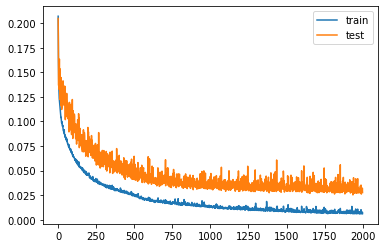

In [150]:
metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

model.compile(
#     optimizer=Adam(1e-3), loss="binary_crossentropy", metrics=metrics
    optimizer=Adam(1e-3), loss="mse", metrics=metrics
#          optimizer=Ftrl(learning_rate=0.001, name="Ftrl"), loss="binary_crossentropy", metrics=metrics
)

callbacks = [keras.callbacks.ModelCheckpoint("thyroid_model_at_epoch_{epoch}.h5")]

history = model.fit(
    X_train,
    y_train,
    batch_size=100,
    epochs=2000,
    verbose=1,
    callbacks=callbacks,
    validation_data=(X_validation, y_validation),
    class_weight=d_class_weights,
)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()


In [151]:
TrainPredictions = model.predict(inputTrain)
TrainPredictions = np.argmax(TrainPredictions, axis=1)

Text(0.5, 15.0, 'Predicted label')

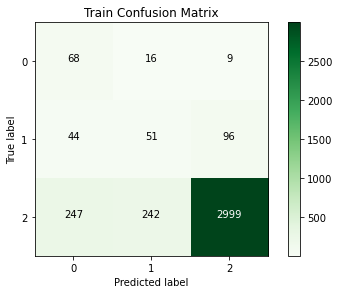

In [152]:
conf = confusion_matrix(outputTrain, TrainPredictions)

classes = [0, 1, 2]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("Train Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [153]:
print('Confusion Matrix\n')
print(conf)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(outputTrain, TrainPredictions)))

print('Micro Precision: {:.2f}'.format(precision_score(outputTrain, TrainPredictions, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(outputTrain, TrainPredictions, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(outputTrain, TrainPredictions, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(outputTrain, TrainPredictions, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(outputTrain, TrainPredictions, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(outputTrain, TrainPredictions, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(outputTrain, TrainPredictions, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(outputTrain, TrainPredictions, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(outputTrain, TrainPredictions, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(outputTrain, TrainPredictions, target_names=['Class 1', 'Class 2', 'Class 3']))

Confusion Matrix

[[  68   16    9]
 [  44   51   96]
 [ 247  242 2999]]

Accuracy: 0.83

Micro Precision: 0.83
Micro Recall: 0.83
Micro F1-score: 0.83

Macro Precision: 0.44
Macro Recall: 0.62
Macro F1-score: 0.47

Weighted Precision: 0.91
Weighted Recall: 0.83
Weighted F1-score: 0.86

Classification Report

              precision    recall  f1-score   support

     Class 1       0.19      0.73      0.30        93
     Class 2       0.17      0.27      0.20       191
     Class 3       0.97      0.86      0.91      3488

    accuracy                           0.83      3772
   macro avg       0.44      0.62      0.47      3772
weighted avg       0.91      0.83      0.86      3772



In [154]:
TestPredictions = model.predict(inputTest)
TestPredictions = np.argmax(TestPredictions, axis=1)

Text(0.5, 15.0, 'Predicted label')

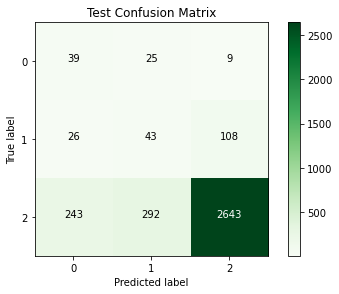

In [155]:
conf = confusion_matrix(outputTest, TestPredictions)

classes = [0, 1, 2]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("Test Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [156]:
print('Confusion Matrix\n')
print(conf)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(outputTest, TestPredictions)))

print('Micro Precision: {:.2f}'.format(precision_score(outputTest, TestPredictions, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(outputTest, TestPredictions, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(outputTest, TestPredictions, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(outputTest, TestPredictions, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(outputTest, TestPredictions, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(outputTest, TestPredictions, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(outputTest, TestPredictions, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(outputTest, TestPredictions, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(outputTest, TestPredictions, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(outputTest, TestPredictions, target_names=['Class 1', 'Class 2', 'Class 3']))

Confusion Matrix

[[  39   25    9]
 [  26   43  108]
 [ 243  292 2643]]

Accuracy: 0.79

Micro Precision: 0.79
Micro Recall: 0.79
Micro F1-score: 0.79

Macro Precision: 0.40
Macro Recall: 0.54
Macro F1-score: 0.42

Weighted Precision: 0.90
Weighted Recall: 0.79
Weighted F1-score: 0.84

Classification Report

              precision    recall  f1-score   support

     Class 1       0.13      0.53      0.20        73
     Class 2       0.12      0.24      0.16       177
     Class 3       0.96      0.83      0.89      3178

    accuracy                           0.79      3428
   macro avg       0.40      0.54      0.42      3428
weighted avg       0.90      0.79      0.84      3428

